# Tutorial 4: Autoregressive models

**Week 2, Day 2: Linear Systems**

**By Neuromatch Academy**

**Content Creators**: Bing Wen Brunton, Biraj Pandey

**Content Reviewers**: Norma Kuhn, John Butler, Matthew Krause, Ella Batty, Richard Gao, Michael Waskom

**Post-Production Team:** Gagana B, Spiros Chavlis

---
# Tutorial Objectives

The goal of this tutorial is to use the modeling tools and intuitions developed in the previous few tutorials and use them to _fit data_. The concept is to flip the previous tutorial -- instead of generating synthetic data points from a known underlying process, what if we are given data points measured in time and have to learn the underlying process?

This tutorial is in two sections.

**Section 1** walks through using regression of data to solve for the coefficient of an OU process from Tutorial 3. Next, **Section 2** generalizes this auto-regression framework to high-order autoregressive models, and we will try to fit data from monkeys at typewriters.

---
# Setup

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Figure settings

In [2]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# Plotting Functions

In [3]:
def plot_residual_histogram(res):
  """Helper function for Exercise 4A"""
  plt.figure()
  plt.hist(res)
  plt.xlabel('error in linear model')
  plt.title(f'stdev of errors = {res.std():.4f}')
  plt.show()


def plot_training_fit(x1, x2, p):
  """Helper function for Exercise 4B"""
  plt.figure()
  plt.scatter(x2 + np.random.standard_normal(len(x2))*0.02,
              np.dot(x1.T, p), alpha=0.2)
  plt.title(f'Training fit, order {r} AR model')
  plt.xlabel('x')
  plt.ylabel('estimated x')
  plt.show()

# Helper Functions

In [4]:
def ddm(T, x0, xinfty, lam, sig):
  '''
  Samples a trajectory of a drift-diffusion model.

  args:
  T (integer): length of time of the trajectory
  x0 (float): position at time 0
  xinfty (float): equilibrium position
  lam (float): process param
  sig: standard deviation of the normal distribution

  returns:
  t (numpy array of floats): time steps from 0 to T sampled every 1 unit
  x (numpy array of floats): position at every time step
  '''
  t = np.arange(0, T, 1.)
  x = np.zeros_like(t)
  x[0] = x0

  for k in range(len(t)-1):
      x[k+1] = xinfty + lam * (x[k] - xinfty) + sig * np.random.standard_normal(size=1)

  return t, x

def build_time_delay_matrices(x, r):
    """
    Builds x1 and x2 for regression

    Args:
    x (numpy array of floats): data to be auto regressed
    r (scalar): order of Autoregression model

    Returns:
    (numpy array of floats) : to predict "x2"
    (numpy array of floats) : predictors of size [r,n-r], "x1"

    """
    # construct the time-delayed data matrices for order-r AR model
    x1 = np.ones(len(x)-r)
    x1 = np.vstack((x1, x[0:-r]))
    xprime = x
    for i in range(r-1):
        xprime = np.roll(xprime, -1)
        x1 = np.vstack((x1, xprime[0:-r]))

    x2 = x[r:]

    return x1, x2


def AR_prediction(x_test, p):
    """
    Returns the prediction for test data "x_test" with the regression
    coefficients p

    Args:
    x_test (numpy array of floats): test data to be predicted
    p (numpy array of floats): regression coefficients of size [r] after
    solving the autoregression (order r) problem on train data

    Returns:
    (numpy array of floats): Predictions for test data. +1 if positive and -1
    if negative.
    """
    x1, x2 = build_time_delay_matrices(x_test, len(p)-1)

    # Evaluating the AR_model function fit returns a number.
    # We take the sign (- or +) of this number as the model's guess.
    return np.sign(np.dot(x1.T, p))

def error_rate(x_test, p):
    """
    Returns the error of the Autoregression model. Error is the number of
    mismatched predictions divided by total number of test points.

    Args:
    x_test (numpy array of floats): data to be predicted
    p (numpy array of floats): regression coefficients of size [r] after
    solving the autoregression (order r) problem on train data

    Returns:
    (float): Error (percentage).
    """
    x1, x2 = build_time_delay_matrices(x_test, len(p)-1)

    return np.count_nonzero(x2 - AR_prediction(x_test, p)) / len(x2)

---
# Section 1: Fitting data to the OU process

To see how this works, let's continue the previous example with the drift-diffusion (OU) process. Our process had the following form:

\begin{equation}
x_{k+1} = x_{\infty} + \lambda(x_k - x_{\infty}) + \sigma \eta
\end{equation}

where $\eta$ is sampled from a standard normal distribution.

For simplicity, we set $x_\infty = 0$. Let's plot a trajectory for this process again below. Take note of the parameters of the process because they will be important later.

### Execute to simulate the drift diffusion model

<>:14: SyntaxWarning: invalid escape sequence '\i'
<>:14: SyntaxWarning: invalid escape sequence '\i'
C:\Users\gstju\AppData\Local\Temp\ipykernel_31716\2658182820.py:14: SyntaxWarning: invalid escape sequence '\i'
  plt.title('$x_0=%d, x_{\infty}=%d, \lambda=%0.1f, \sigma=%0.1f$' % (x0, xinfty, lam, sig))
C:\Users\gstju\AppData\Local\Temp\ipykernel_31716\2737282840.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[k+1] = xinfty + lam * (x[k] - xinfty) + sig * np.random.standard_normal(size=1)


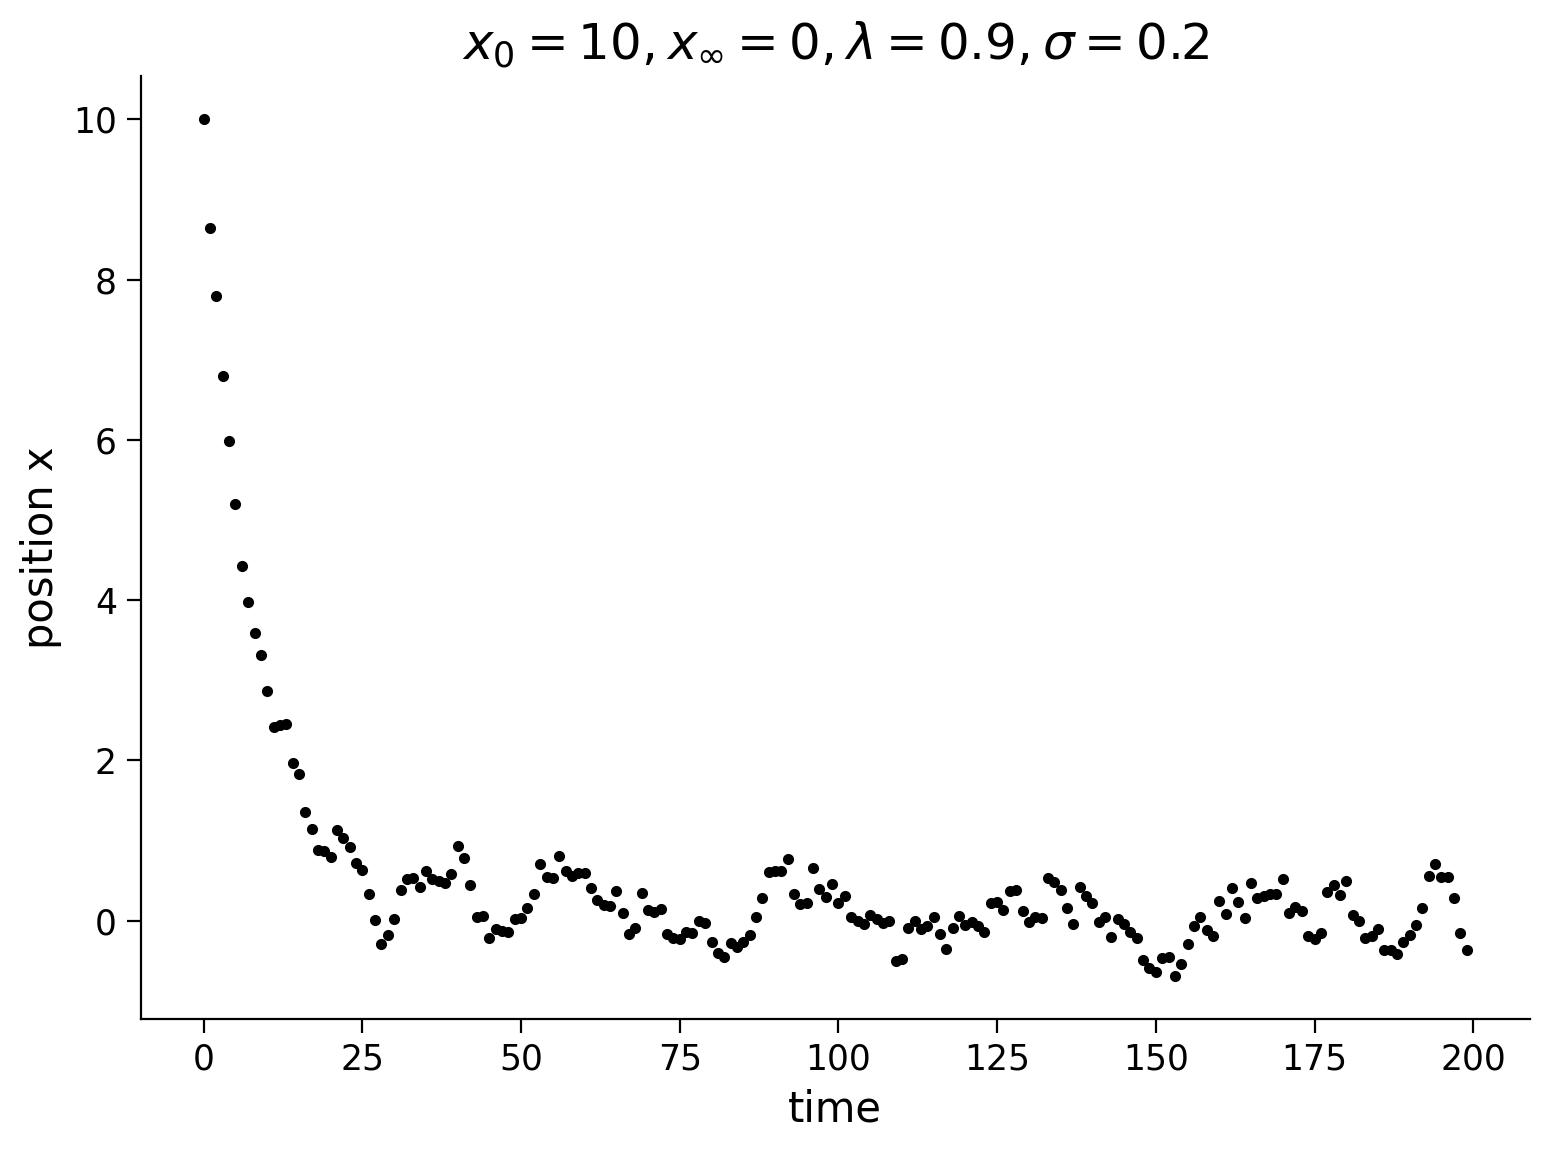

In [5]:
np.random.seed(2020) # set random seed

# parameters
T = 200
x0 = 10
xinfty = 0
lam = 0.9
sig = 0.2

# drift-diffusion model from tutorial 3
t, x = ddm(T, x0, xinfty, lam, sig)

plt.figure()
plt.title('$x_0=%d, x_{\infty}=%d, \lambda=%0.1f, \sigma=%0.1f$' % (x0, xinfty, lam, sig))
plt.plot(t, x, 'k.')
plt.xlabel('time')
plt.ylabel('position x')
plt.show()

What if we were given these positions $x$ as they evolve in time as data, how would we get back out the dynamics of the system $\lambda$?

Since a little bird told us that this system takes on the form

\begin{equation}
x_{k+1} = \lambda x_k + \eta \,,
\end{equation}

where $\eta$ is noise from a normal distribution, our approach is to solve for $\lambda$ as a **regression problem**.

As a check, let's plot every pair of points adjacent in time ($x_{k+1}$ vs. $x_k$) against each other to see if there is a linear relationship between them.

### Execute to visualize X(k) vs. X(k+1)

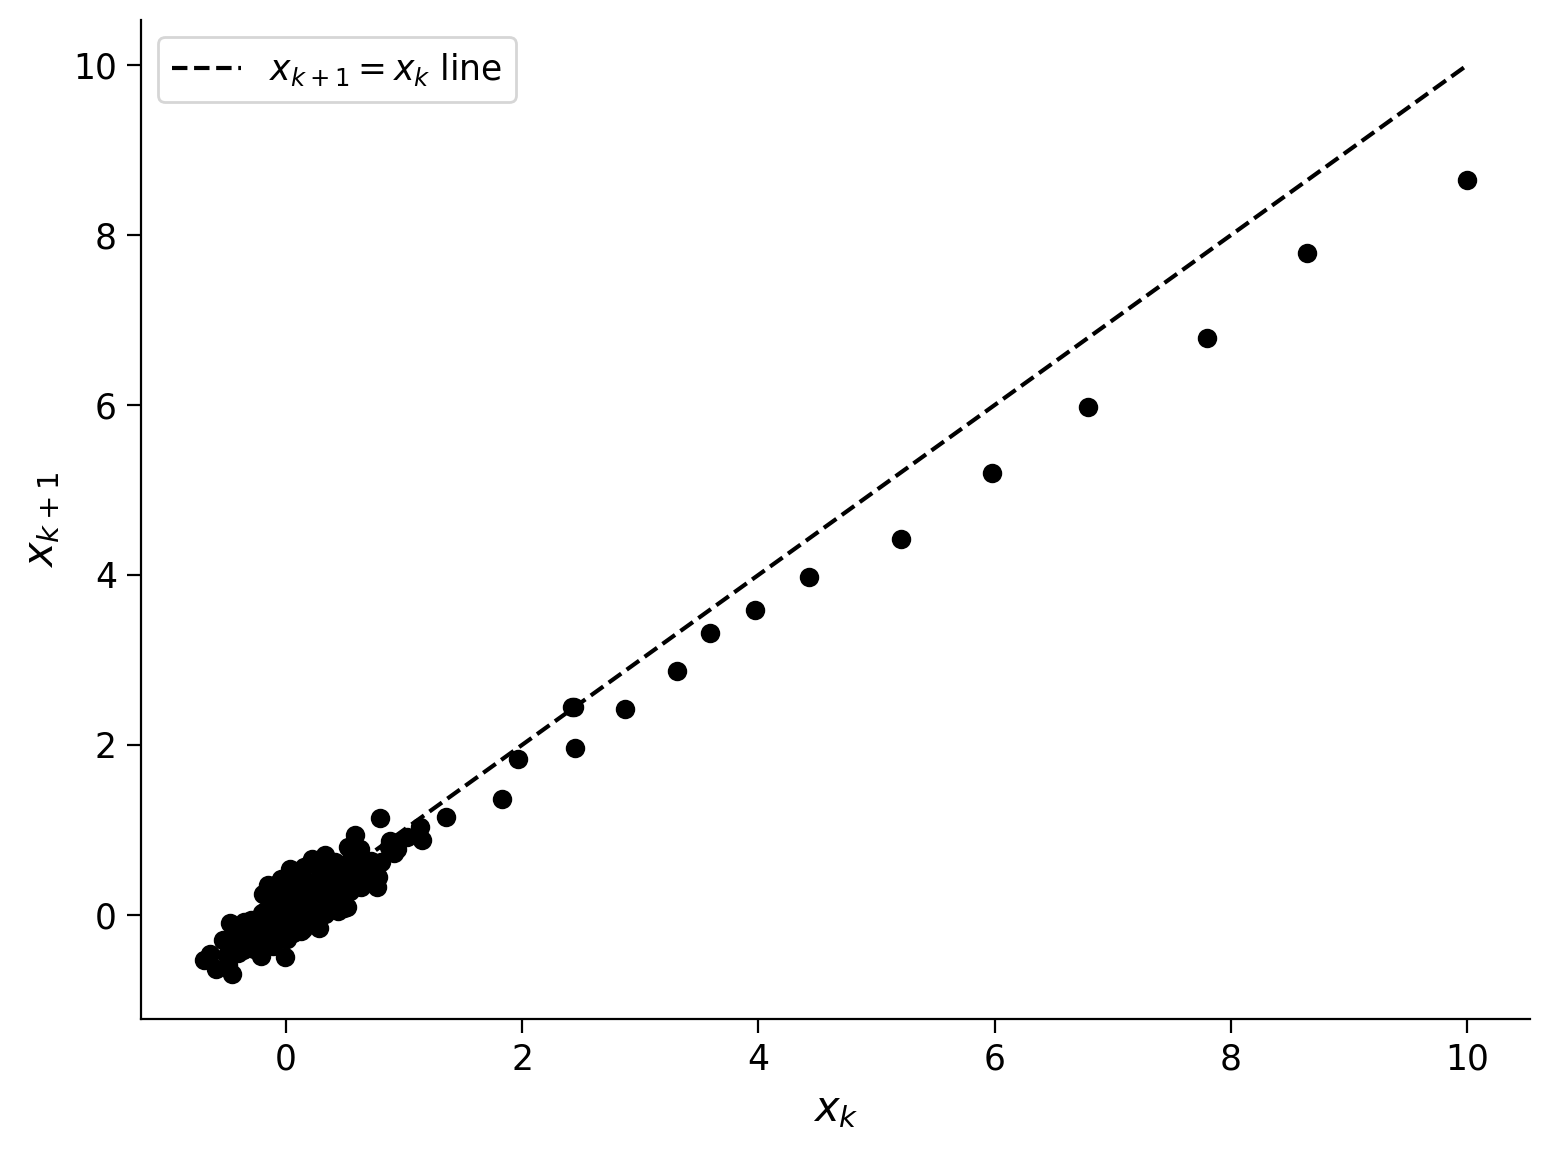

In [6]:
# make a scatter plot of every data point in x
# at time k versus time k+1
plt.figure()
plt.scatter(x[0:-2], x[1:-1], color='k')
plt.plot([0, 10], [0, 10], 'k--', label='$x_{k+1} = x_k$ line')
plt.xlabel('$x_k$')
plt.ylabel('$x_{k+1}$')
plt.legend()
plt.show()

Hooray, it's a line! This is evidence that the _dynamics that generated the data_ is **linear**. We can now reformulate this task as a regression problem.

Let $\mathbf{x_1} = x_{0:T-1}$ and $\mathbf{x_2} = x_{1:T}$ be vectors of the data indexed so that they are shifted in time by one. Then, our regression problem is

\begin{equation}
\mathbf{x}_2 = \lambda \mathbf{x}_1
\end{equation}

This model is **autoregressive**, where _auto_ means self. In other words, it's a regression of the time series on itself from the past. The equation as written above is only a function of itself from _one step_ in the past, so we can call it a _first order_ autoregressive model.

Now, let's set up the regression problem below and solve for $\lambda.$ We will plot our data with the regression line to see if they agree.

### Execute to solve for lambda through autoregression

<>:32: SyntaxWarning: invalid escape sequence '\l'
<>:32: SyntaxWarning: invalid escape sequence '\l'
C:\Users\gstju\AppData\Local\Temp\ipykernel_31716\486171711.py:32: SyntaxWarning: invalid escape sequence '\l'
  mytitle = 'True $\lambda$ = {lam:.4f}, Estimate $\lambda$ = {lam_hat:.4f}'


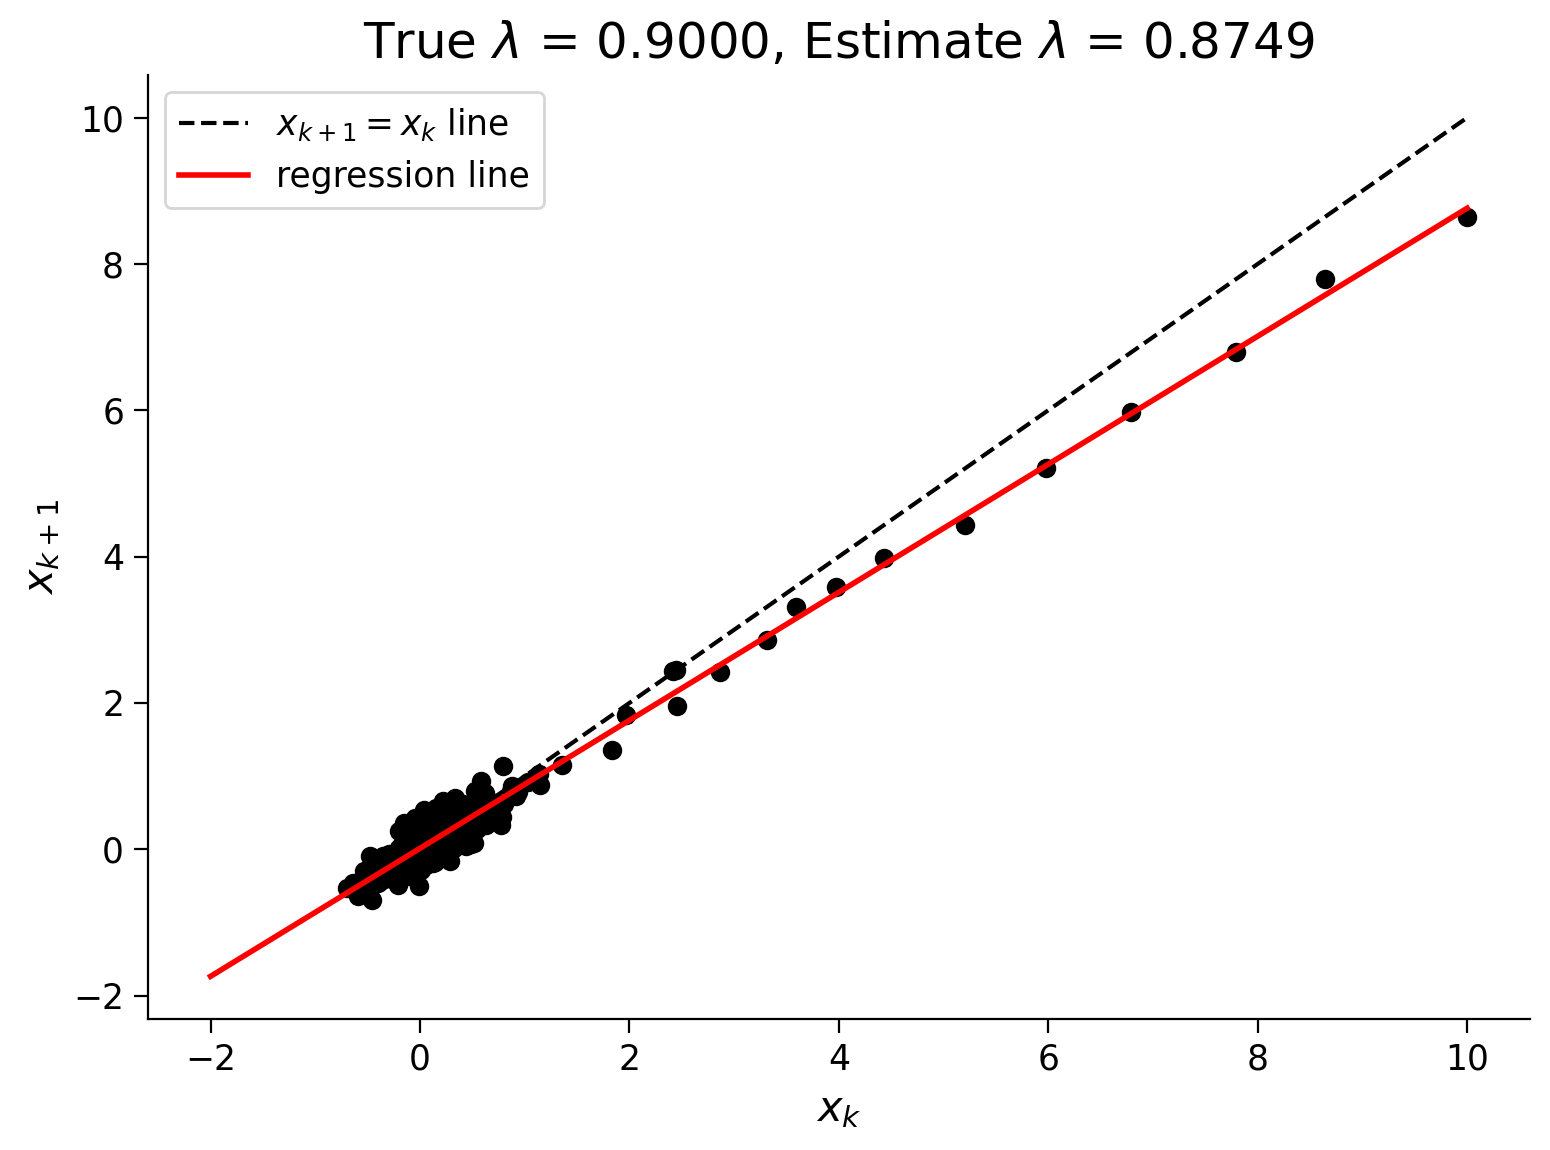

In [7]:
# build the two data vectors from x
x1 = x[0:-2]
x1 = x1[:, np.newaxis]**[0, 1]

x2 = x[1:-1]

# solve for an estimate of lambda as a linear regression problem
p, res, rnk, s = np.linalg.lstsq(x1, x2, rcond=None)

# here we've artificially added a vector of 1's to the x1 array,
# so that our linear regression problem has an intercept term to fit.
# we expect this coefficient to be close to 0.
# the second coefficient in the regression is the linear term:
# that's the one we're after!
lam_hat = p[1]

# plot the data points
fig = plt.figure()
plt.scatter(x[0:-2], x[1:-1], color='k')
plt.xlabel('$x_k$')
plt.ylabel('$x_{k+1}$')

# plot the 45 degree line
plt.plot([0, 10], [0, 10], 'k--', label='$x_{k+1} = x_k$ line')


# plot the regression line on top
xx = np.linspace(-sig*10, max(x), 100)
yy = p[0] + lam_hat * xx
plt.plot(xx, yy, 'r', linewidth=2, label='regression line')

mytitle = 'True $\lambda$ = {lam:.4f}, Estimate $\lambda$ = {lam_hat:.4f}'
plt.title(mytitle.format(lam=lam, lam_hat=lam_hat))
plt.legend()
plt.show()

Pretty cool! So now we have a way to predict $x_{k+1}$ if given any data point $x_k$. Let's take a look at how accurate this one-step prediction might be by plotting the residuals.

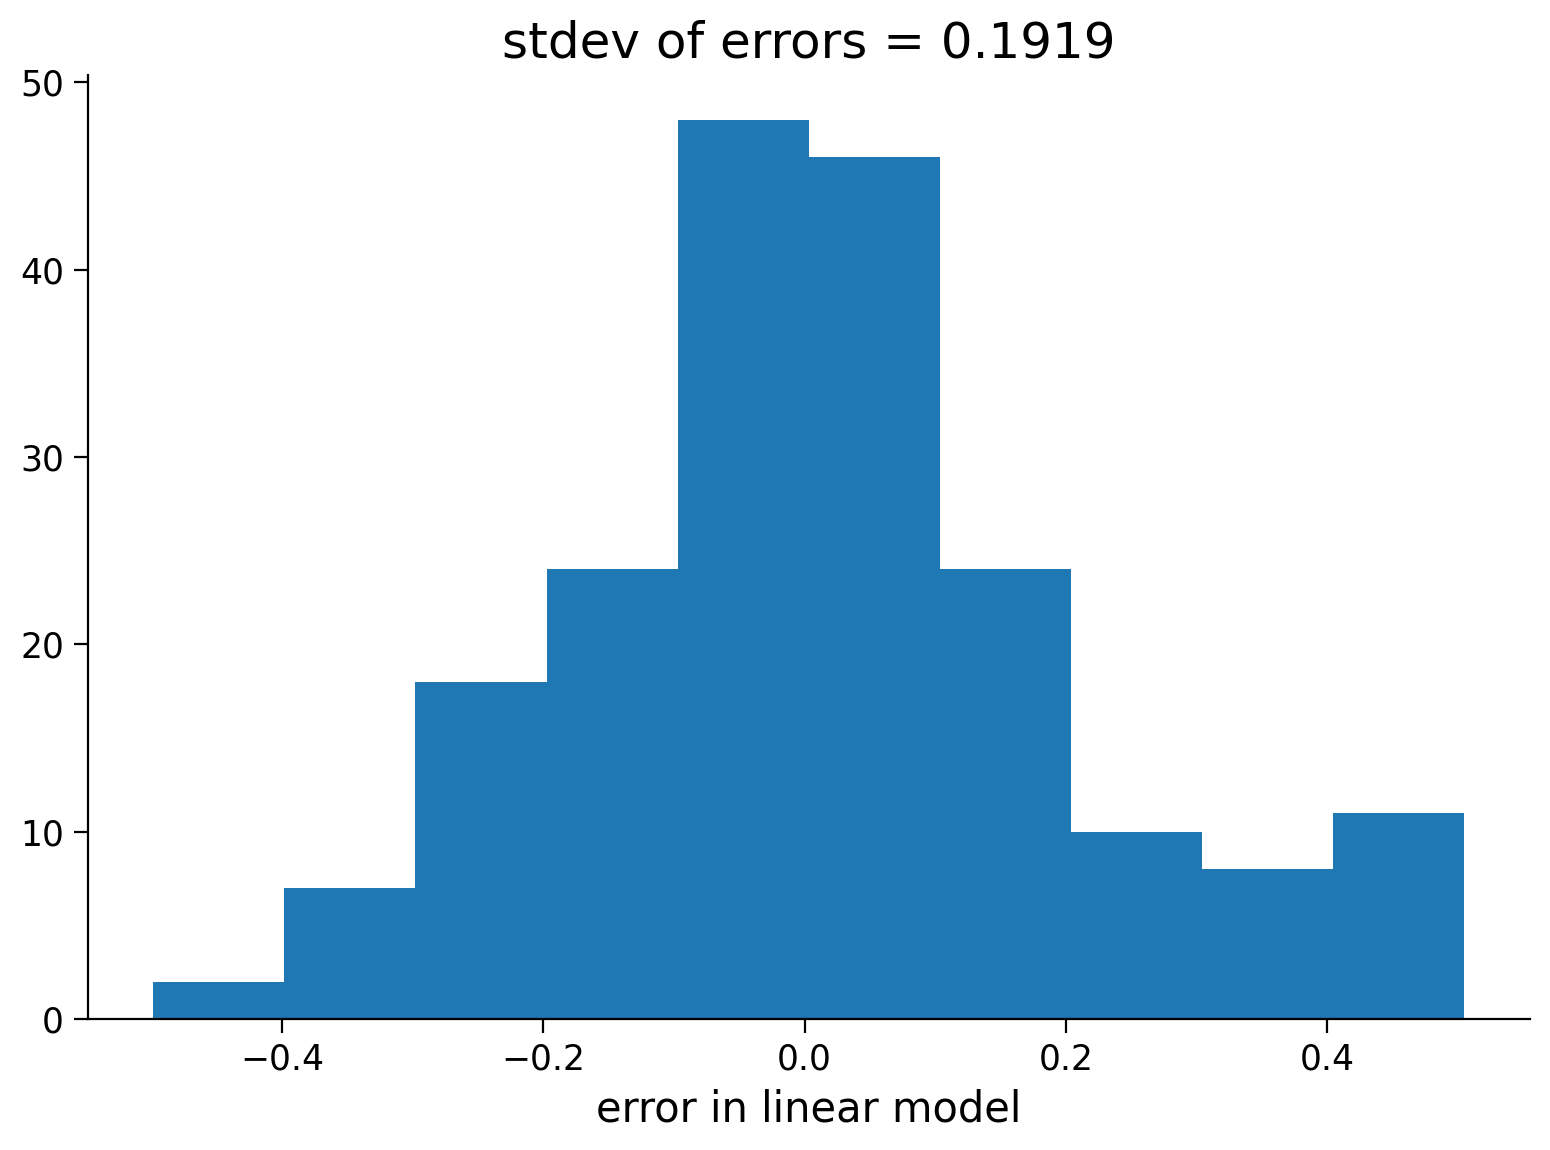

In [8]:
##############################################################################
## Insert your code here take to compute the residual (error)
# raise NotImplementedError('student exercise: compute the residual error')
##############################################################################
# compute the predicted values using the autoregressive model (lam_hat), and
# the residual is the difference between x2 and the prediction
res = x2 - lam_hat * x[0:-2]

# Visualize
plot_residual_histogram(res)

---
# Section 2: Higher order autoregressive models

Now that we have established the autoregressive framework, generalizing for dependence on data points from the past is straightforward. **Higher order** autoregression models a future time point based on _more than one point in the past_.

In one dimension, we can write such an order-$r$ model as

\begin{equation}
x_{k+1} = \alpha_0 + \alpha_1 x_k + \alpha_2 x_{k-1} + \alpha_3 x_{k-2} + \dots + \alpha_{r+1} x_{k-r} \, ,
\end{equation}

where the $\alpha$'s are the $r+1$ coefficients to be fit to the data available.

These models are useful to account for some **history dependence** in the trajectory of time series. This next part of the tutorial will explore one such time series, and you can do an experiment on yourself!

In particular, we will explore a binary random sequence of 0's and 1's that would occur if you flipped a coin and jotted down the flips.

The difference is that, instead of actually flipping a coin (or using code to generate such a sequence), you -- yes you, human -- are going to generate such a random Bernoulli sequence as best as you can by typing in 0's and 1's. We will then build higher-order AR models to see if we can identify predictable patterns in the time-history of digits you generate.

**But first**, let's try this on a sequence with a simple pattern, just to make sure the framework is functional. Below, we generate an entirely predictable sequence and plot it.

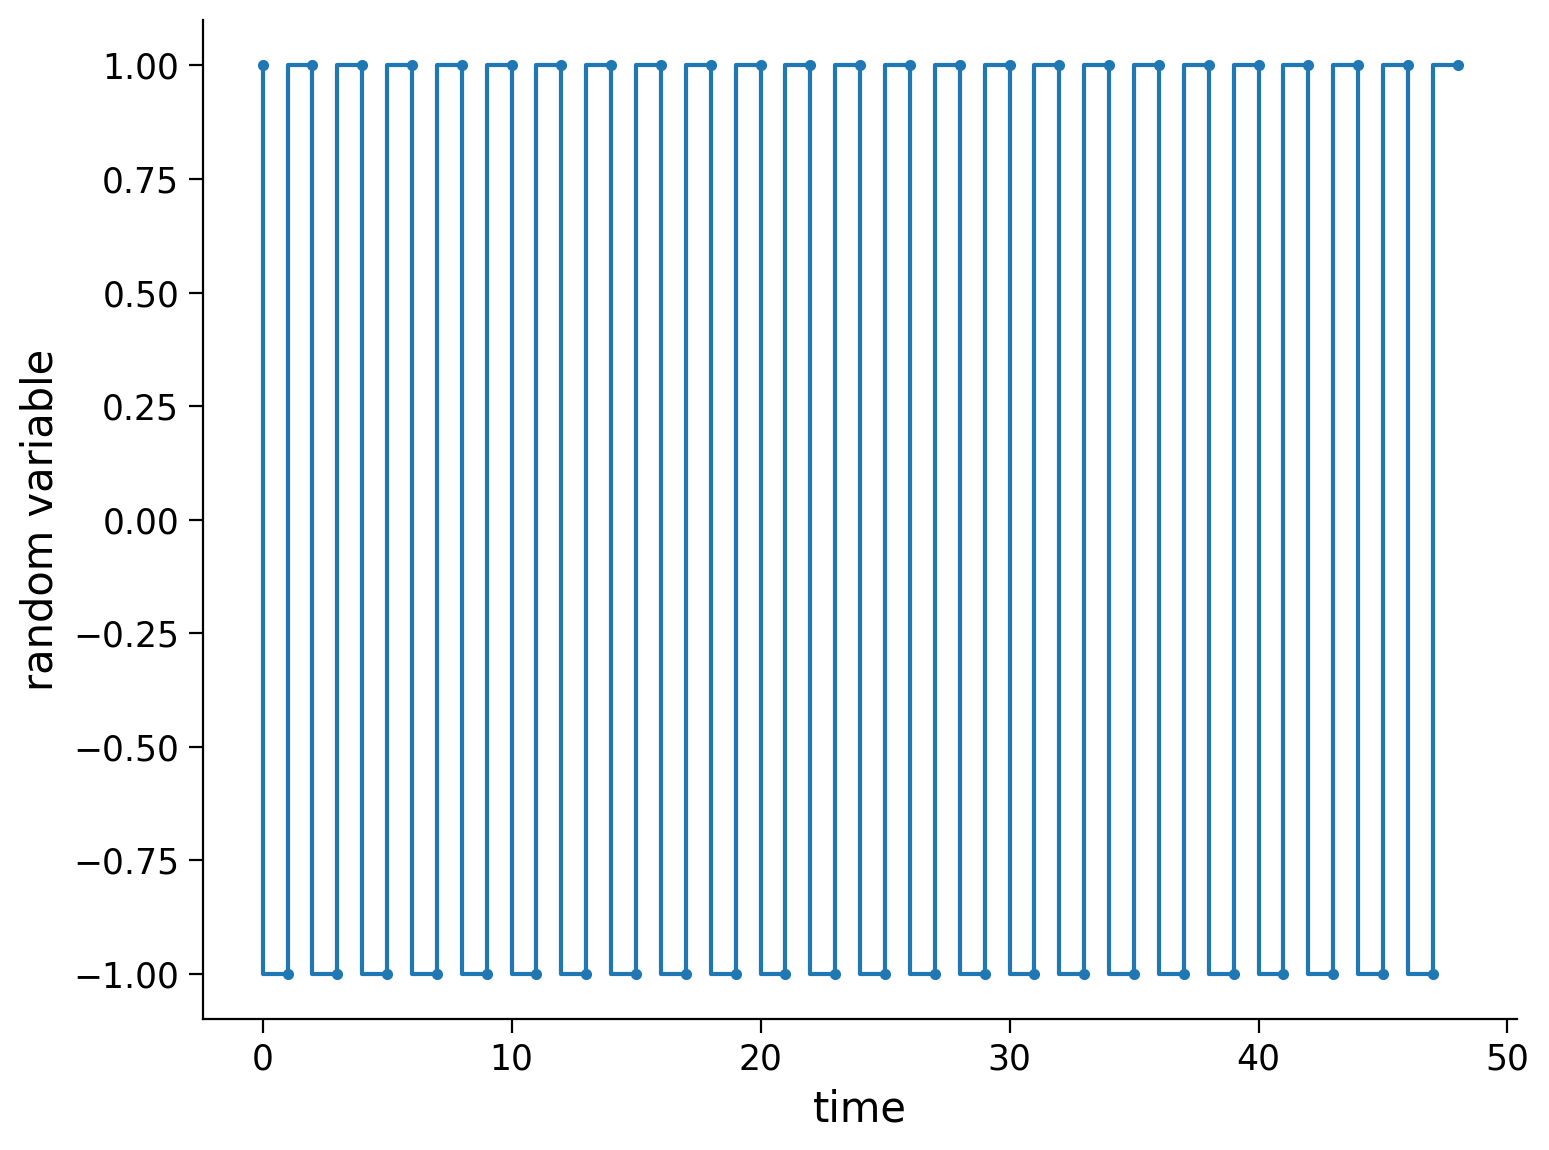

In [9]:
# this sequence is entirely predictable, so an AR model should work
monkey_at_typewriter = '1010101010101010101010101010101010101010101010101'

# Bonus: this sequence is also predictable, but does an order-1 AR model work?
#monkey_at_typewriter = '100100100100100100100100100100100100100'

# function to turn chars to numpy array,
# coding it this way makes the math easier
# '0' -> -1
# '1' -> +1
def char2array(s):
  m = [int(c) for c in s]
  x = np.array(m)
  return x*2 - 1


x = char2array(monkey_at_typewriter)

plt.figure()
plt.step(x, '.-')
plt.xlabel('time')
plt.ylabel('random variable')
plt.show()

Now, let's set up our regression problem (order 1 autoregression like above) by defining $\mathbf{x_1}$ and $\mathbf{x_2}$ and solve it.

In [10]:
# build the two data vectors from x
x1 = x[0:-2]
x1 = x1[:, np.newaxis]**[0, 1]

x2 = x[1:-1]

# solve for an estimate of lambda as a linear regression problem
p, res, rnk, s = np.linalg.lstsq(x1, x2, rcond=None)

In [11]:
# take a look at the resulting regression coefficients
print(f'alpha_0 = {p[0]:.2f}, alpha_1 = {p[1]:.2f}')

alpha_0 = -0.00, alpha_1 = -1.00


## Think! 2: Understanding autoregressive parameters

Do the values we got for $\alpha_0$ and $\alpha_1$ make sense? Write down the corresponding autoregressive model and convince yourself that it gives the alternating 0's and 1's we asked it to fit as data.

Truly random sequences of numbers have no structure and should not be predictable by an AR or any other models.

However, humans are notoriously terrible at generating random sequences of numbers! (Other animals are no better...)

To test out an application of higher-order AR models, let's use them to **model a sequence of 0's and 1's that a human tried to produce at random**. In particular, I convinced my 9-yr-old monkey to sit at a typewriter (my laptop) and enter some digits as randomly as he is able. The digits he typed in are in the code, and we can plot them as a time series of digits here.

If the digits really have no structure, then we expect our model to do about as well as guessing, producing an error rate of 0.5. Let's see how well we can do!

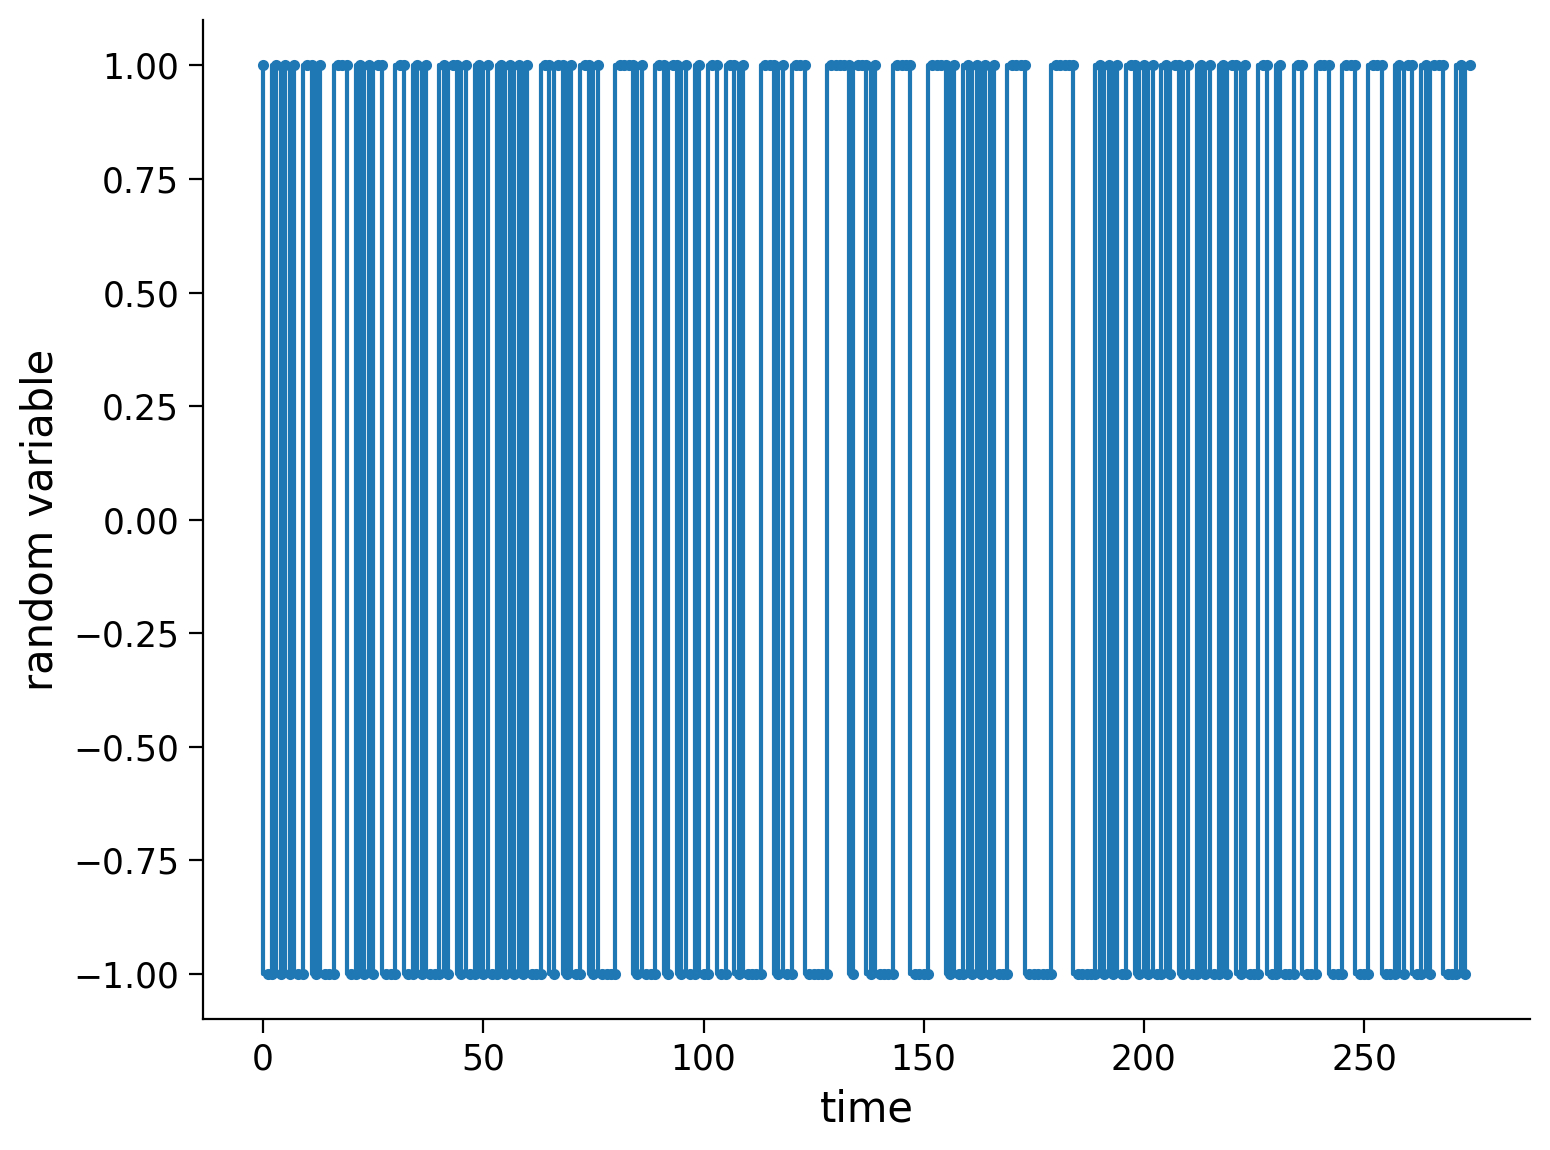

In [12]:
# data generated by 9-yr-old JAB:
# we will be using this sequence to train the data
monkey_at_typewriter = '10010101001101000111001010110001100101000101101001010010101010001101101001101000011110100011011010010011001101000011101001110000011111011101000011110000111101001010101000111100000011111000001010100110101001011010010100101101000110010001100011100011100011100010110010111000101'

# we will be using this sequence to test the data
test_monkey = '00100101100001101001100111100101011100101011101001010101000010110101001010100011110'

x = char2array(monkey_at_typewriter)
test = char2array(test_monkey)

## testing: machine generated randint should be entirely unpredictable
## uncomment the lines below to try random numbers instead
# np.random.seed(2020) # set random seed
# x = char2array(np.random.randint(2, size=500))
# test = char2array(np.random.randint(2, size=500))

plt.figure()
plt.step(x, '.-')
plt.xlabel('time')
plt.ylabel('random variable')
plt.show()

## Coding Exercise 2: Fitting AR models

Fit a order-5 ($r=5$) AR model to the data vector $x$. To do this, we have included some helper functions, including ``AR_model``.

We will then plot the observations against the trained model. Note that this means we are using a sequence of the previous 5 digits to predict the next one.

Additionally, output from our regression model is continuous (real numbers) whereas our data are scalar (+1/-1). So, we will take the sign of our continuous outputs (+1 if positive and -1 if negative) as our predictions to make them comparable with data. Our error rate will simply be the number of mismatched predictions divided by the total number of predictions.

Execute this cell to get helper function `AR_model`

In [13]:
def AR_model(x, r):
    """
    Solves Autoregression problem of order (r) for x

    Args:
    x (numpy array of floats): data to be auto regressed
    r (scalar): order of Autoregression model

    Returns:
    (numpy array of floats) : to predict "x2"
    (numpy array of floats) : predictors of size [r,n-r], "x1"
    (numpy array of floats): coefficients of length [r] for prediction after
    solving the regression problem "p"
    """
    x1, x2 = build_time_delay_matrices(x, r)

    # solve for an estimate of lambda as a linear regression problem
    p, res, rnk, s = np.linalg.lstsq(x1.T, x2, rcond=None)

    return x1, x2, p

help(AR_model)

Help on function AR_model in module __main__:

AR_model(x, r)
    Solves Autoregression problem of order (r) for x

    Args:
    x (numpy array of floats): data to be auto regressed
    r (scalar): order of Autoregression model

    Returns:
    (numpy array of floats) : to predict "x2"
    (numpy array of floats) : predictors of size [r,n-r], "x1"
    (numpy array of floats): coefficients of length [r] for prediction after
    solving the regression problem "p"



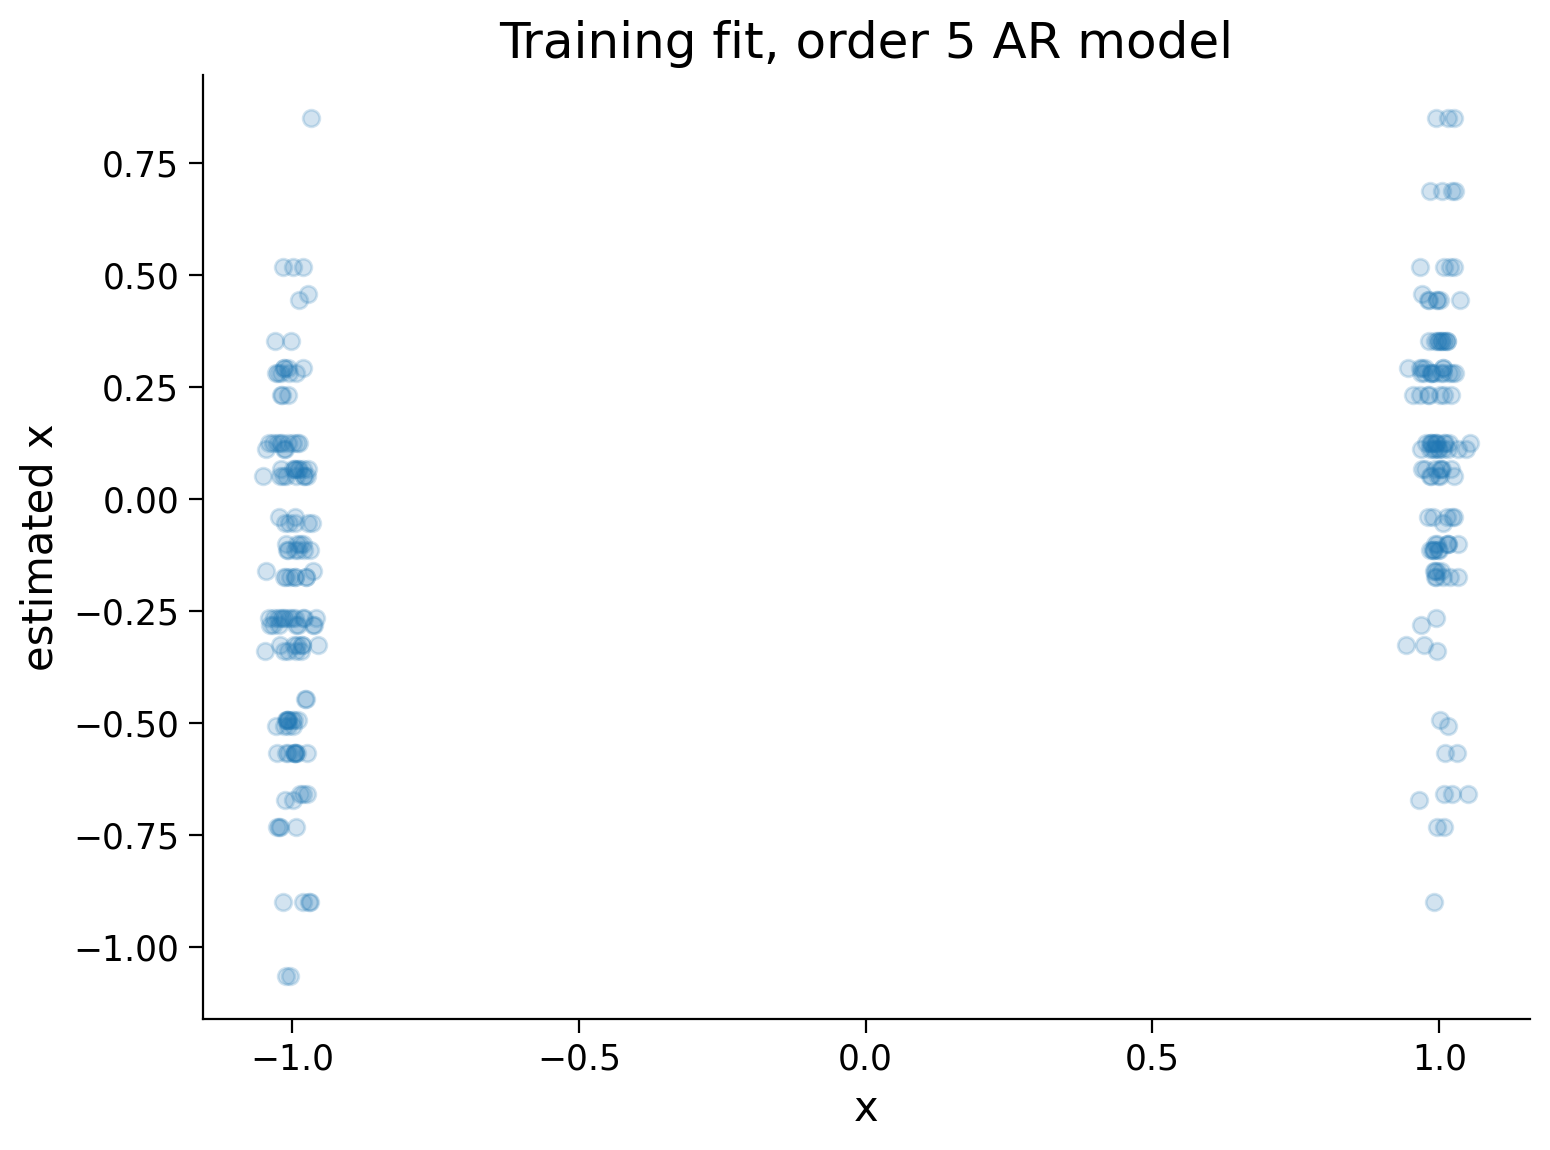

In [14]:
##############################################################################
## TODO: Insert your code here for fitting the AR model
#raise NotImplementedError('student exercise: fit AR model')
##############################################################################
# define the model order, and use AR_model() to generate the model and prediction
r = 5
x1, x2, p = AR_model(x, r)

# Plot the Training data fit
# Note that this adds a small amount of jitter to horizontal axis for visualization purposes
plot_training_fit(x1, x2, p)

Let's check out how the model does on the test data that it's never seen before!

Execute to see model performance on test data

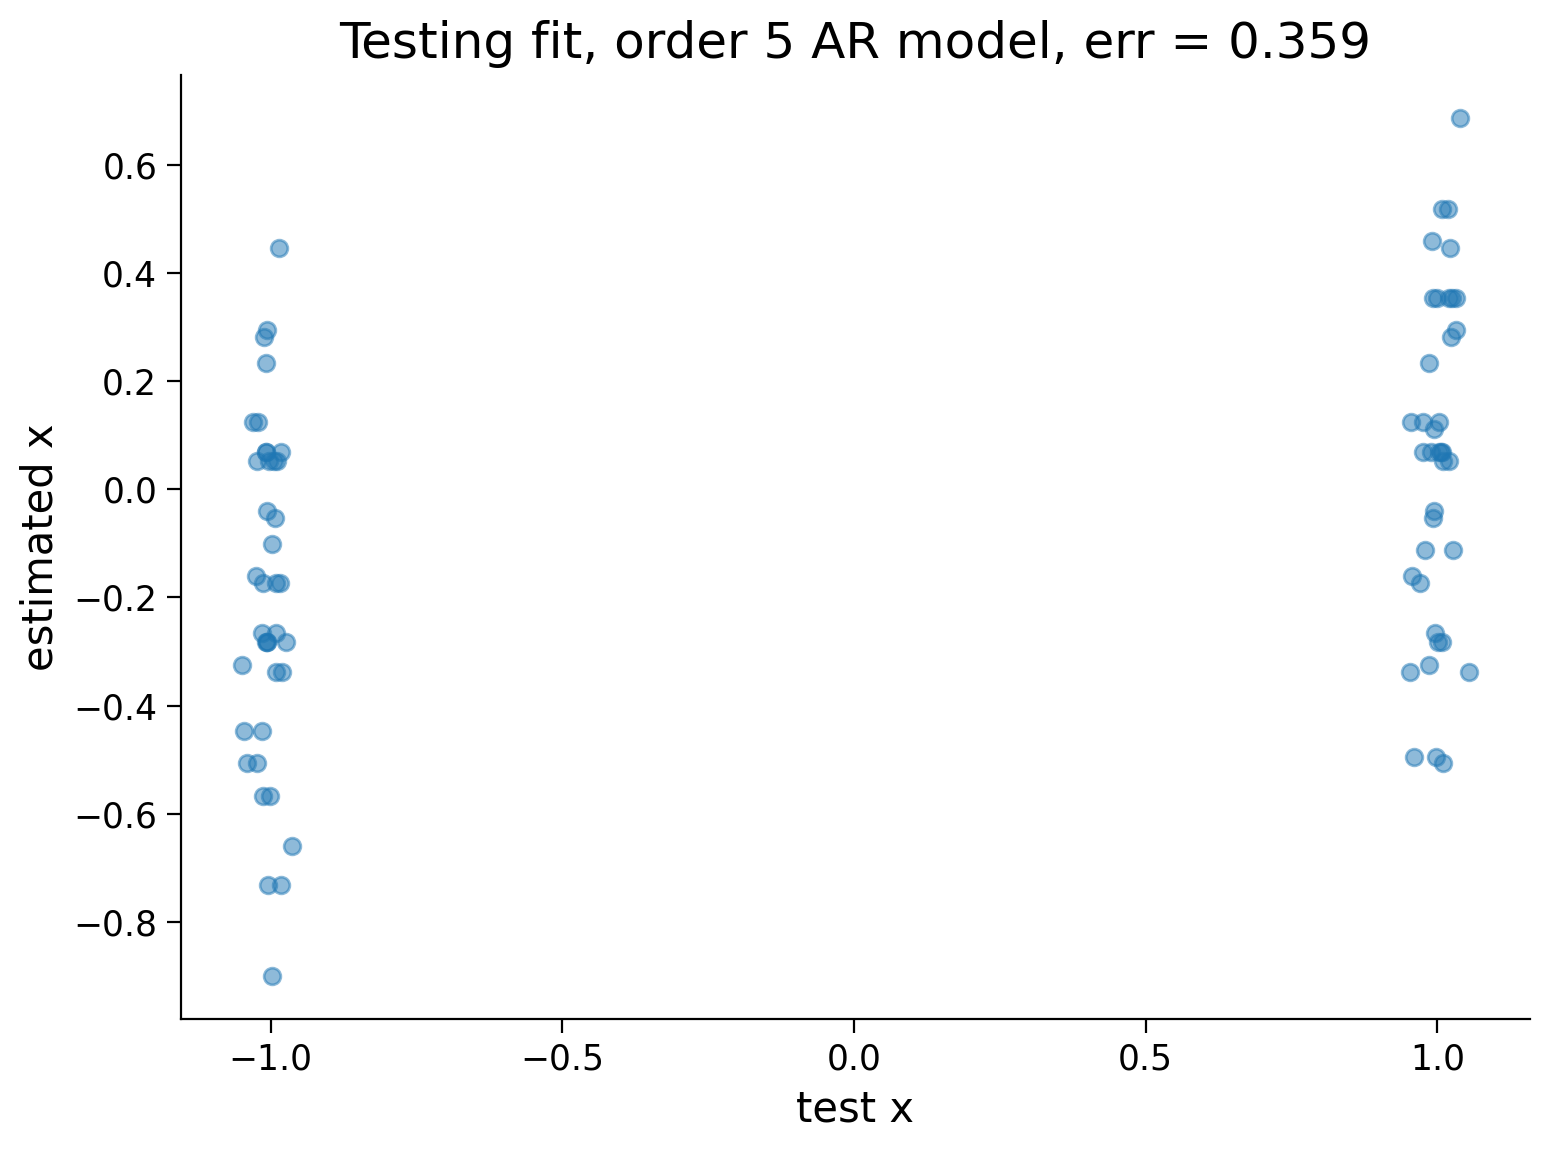

In [15]:
x1_test, x2_test = build_time_delay_matrices(test, r)
plt.figure()
plt.scatter(x2_test+np.random.standard_normal(len(x2_test))*0.02,
            np.dot(x1_test.T, p), alpha=0.5)
mytitle = f'Testing fit, order {r} AR model, err = {error_rate(test, p):.3f}'
plt.title(mytitle)
plt.xlabel('test x')
plt.ylabel('estimated x')
plt.show()

Not bad! We're getting errors that are smaller than 0.5 (what we would have gotten by chance).

Let's now try **AR models of different orders** systematically, and plot the test error of each.

_Remember_: The model has never seen the test data before, and random guessing would produce an error of $0.5$.

Execute to visualize errors for different orders

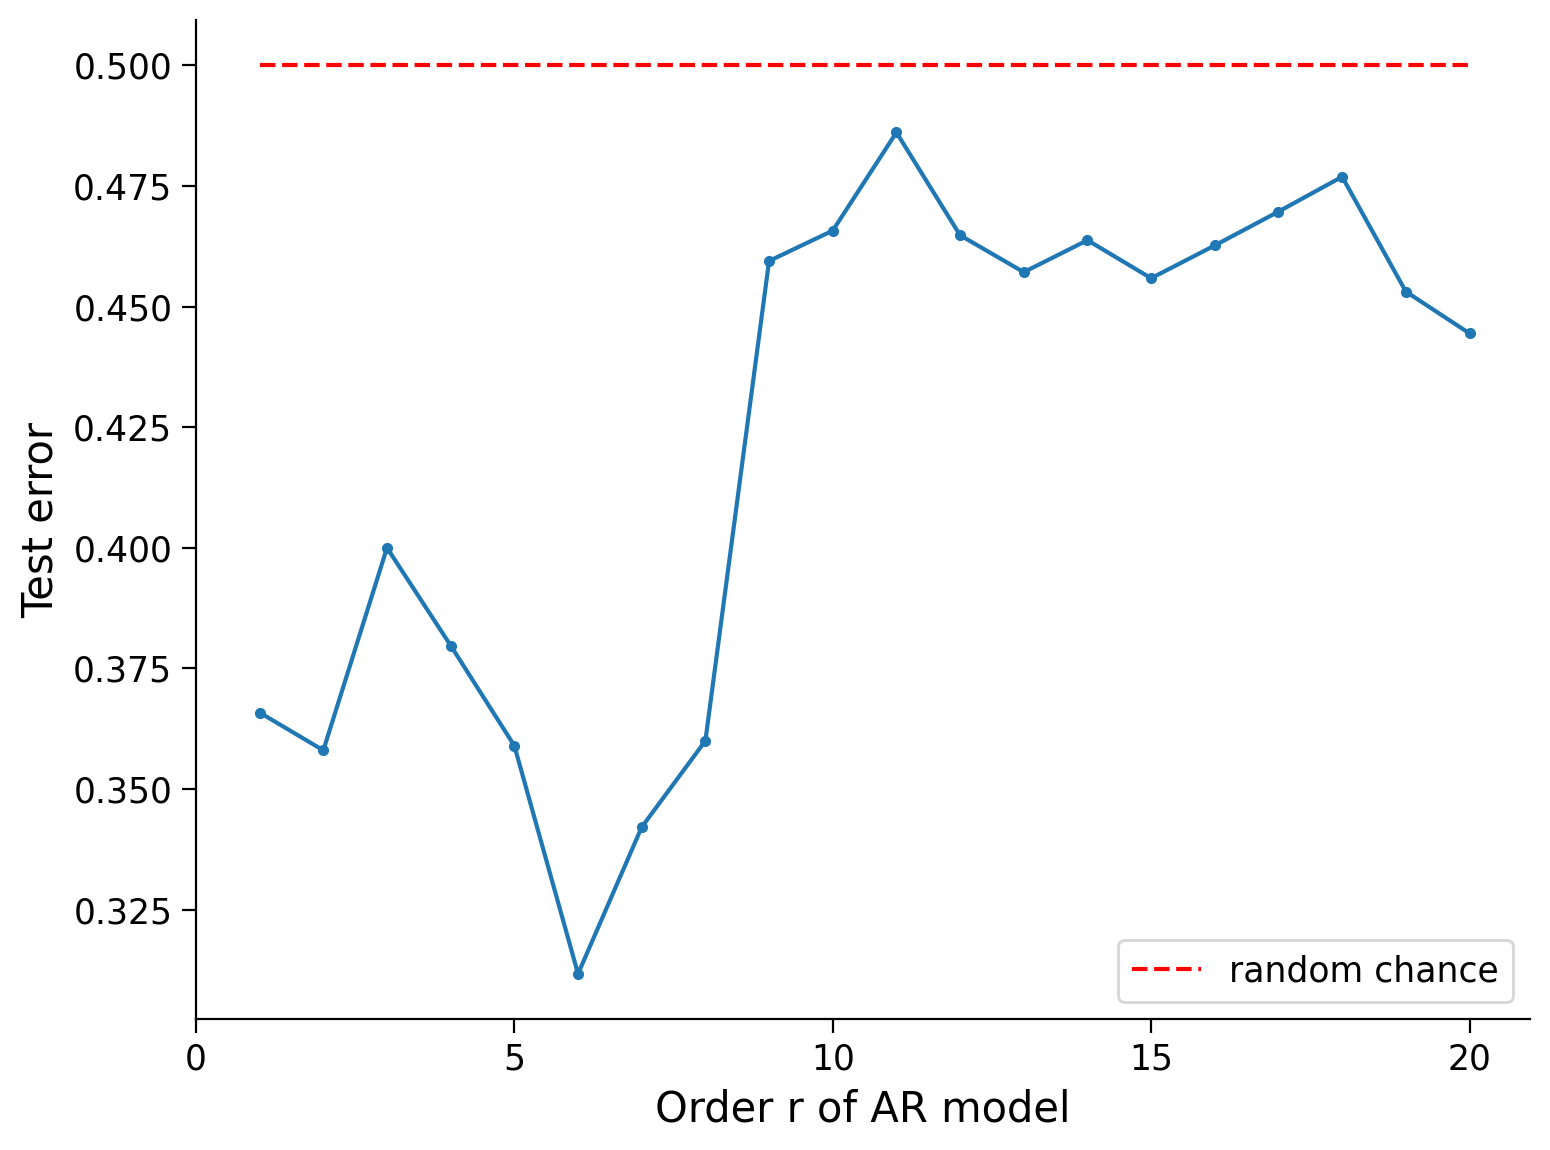

In [16]:
# range of r's to try
r = np.arange(1, 21)
err = np.ones_like(r) * 1.0

for i, rr in enumerate(r):
  # fitting the model on training data
  x1, x2, p = AR_model(x, rr)
  # computing and storing the test error
  test_error = error_rate(test, p)
  err[i] = test_error


plt.figure()
plt.plot(r, err, '.-')
plt.plot([1, r[-1]], [0.5, 0.5], 'r--', label='random chance')
plt.xlabel('Order r of AR model')
plt.ylabel('Test error')
plt.xticks(np.arange(0,25,5))
plt.legend()
plt.show()

Notice that there's a sweet spot in the test error! The 6th order AR model does a really good job here, and for larger $r$'s, the model starts to overfit the training data and does not do well on the test data.

---
# Summary

*Estimated timing of tutorial: 30 minutes*

In this tutorial, we learned:

* How learning the parameters of a linear dynamical system can be formulated as a regression problem from data.
* Time-history dependence can be incorporated into the regression framework as a multiple regression problem.
* That humans are no good at generating random (not predictable) sequences. Try it on yourself!

# Bonus: Testing withmachine generated `randint`

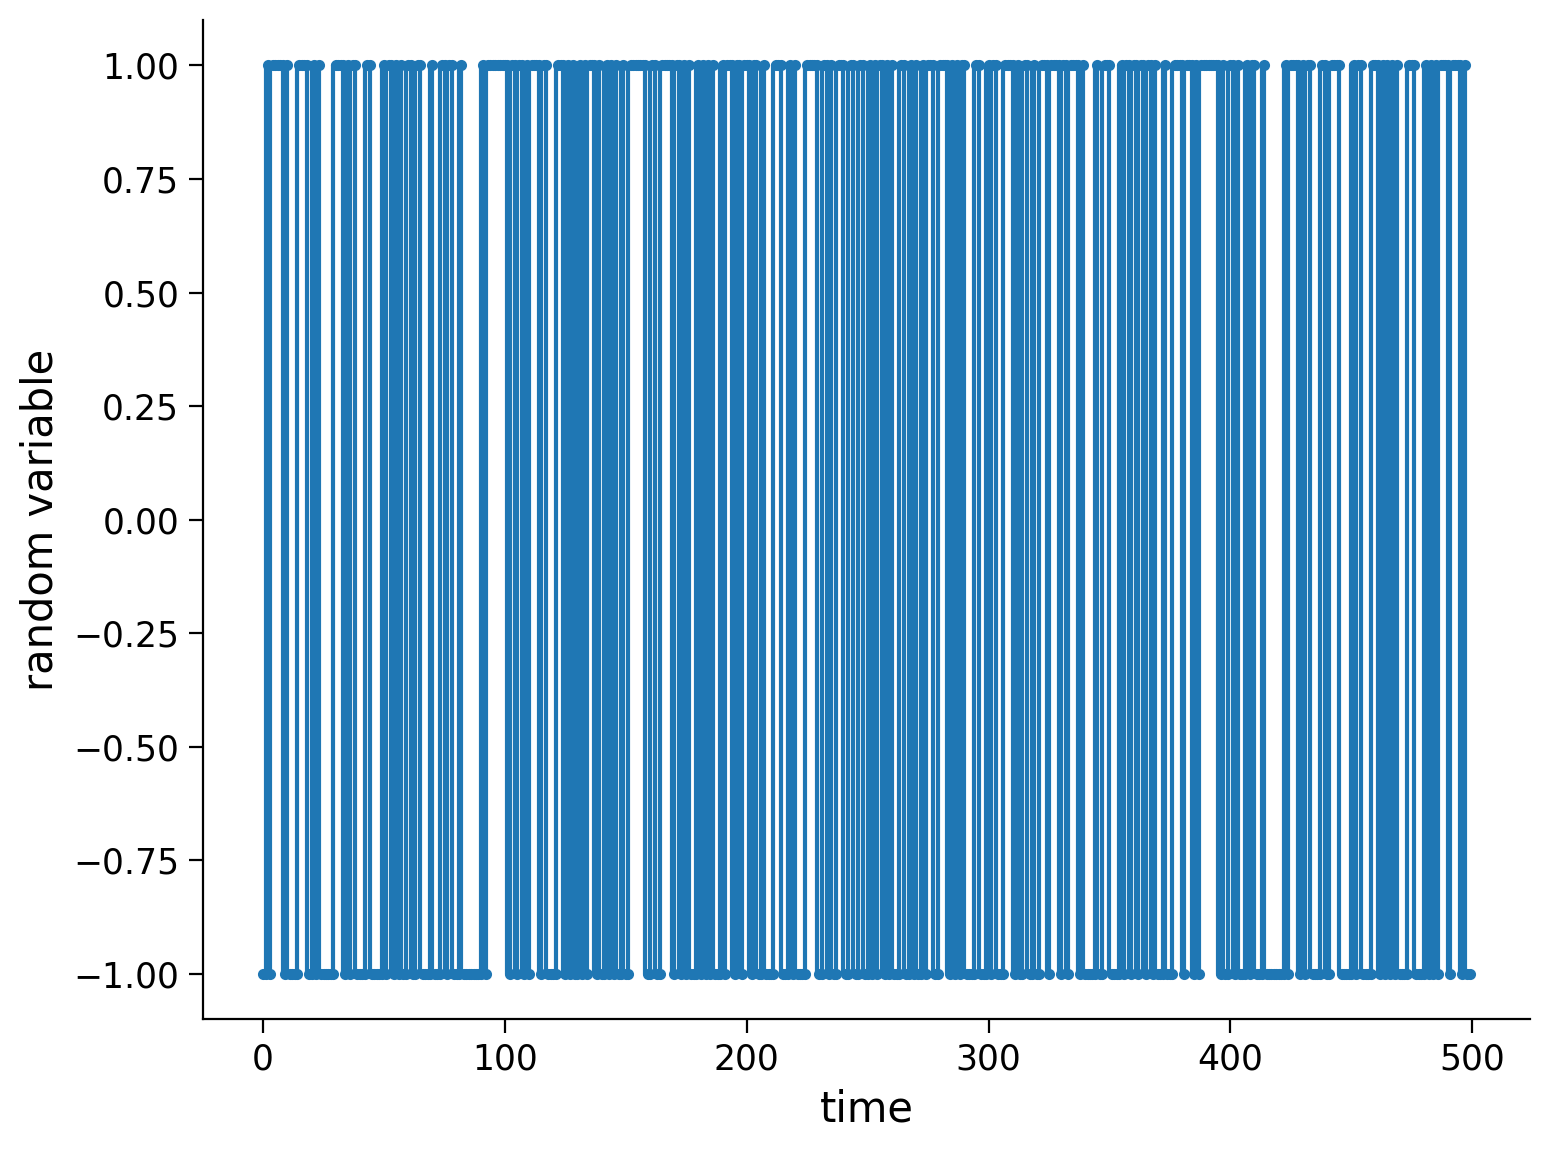

In [18]:
## testing: machine generated randint should be entirely unpredictable
## uncomment the lines below to try random numbers instead
np.random.seed(2020) # set random seed
x = char2array(np.random.randint(2, size=500))
test = char2array(np.random.randint(2, size=500))

plt.figure()
plt.step(x, '.-')
plt.xlabel('time')
plt.ylabel('random variable')
plt.show()

## Fitting AR models

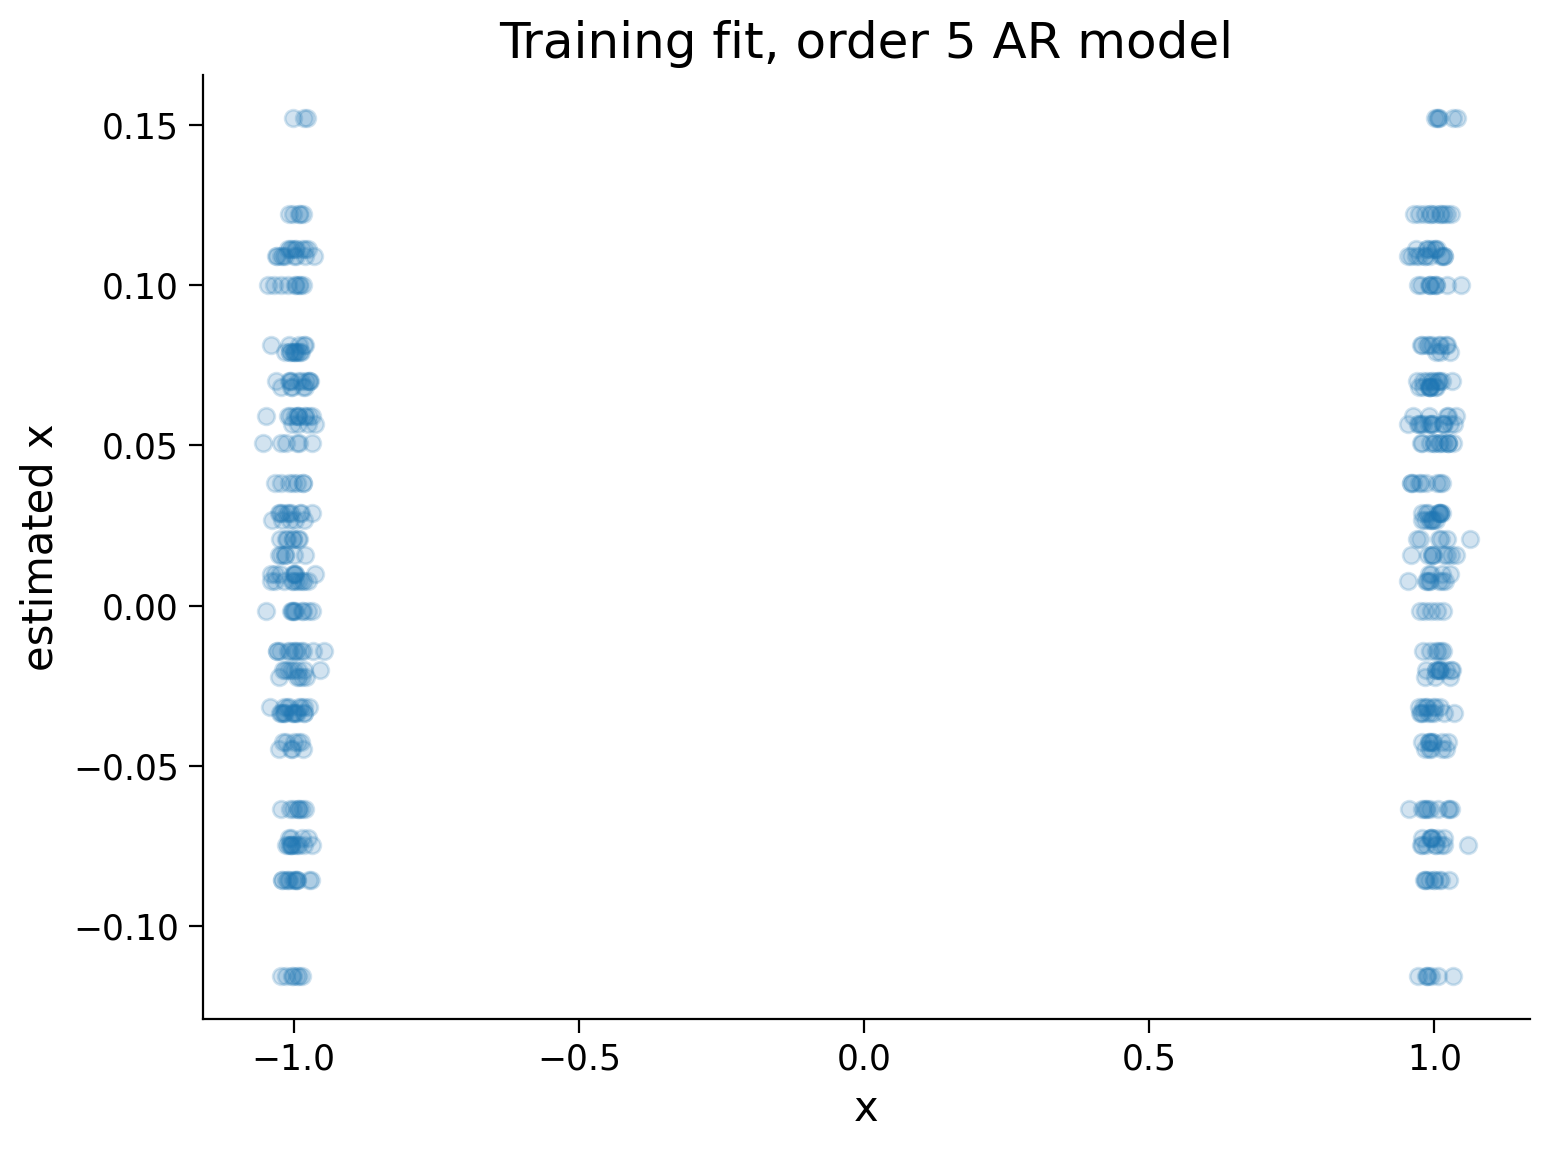

In [19]:
# define the model order, and use AR_model() to generate the model and prediction
r = 5
x1, x2, p = AR_model(x, r)

# Plot the Training data fit
# Note that this adds a small amount of jitter to horizontal axis for visualization purposes
plot_training_fit(x1, x2, p)

Execute to see model performance on machine generated test data

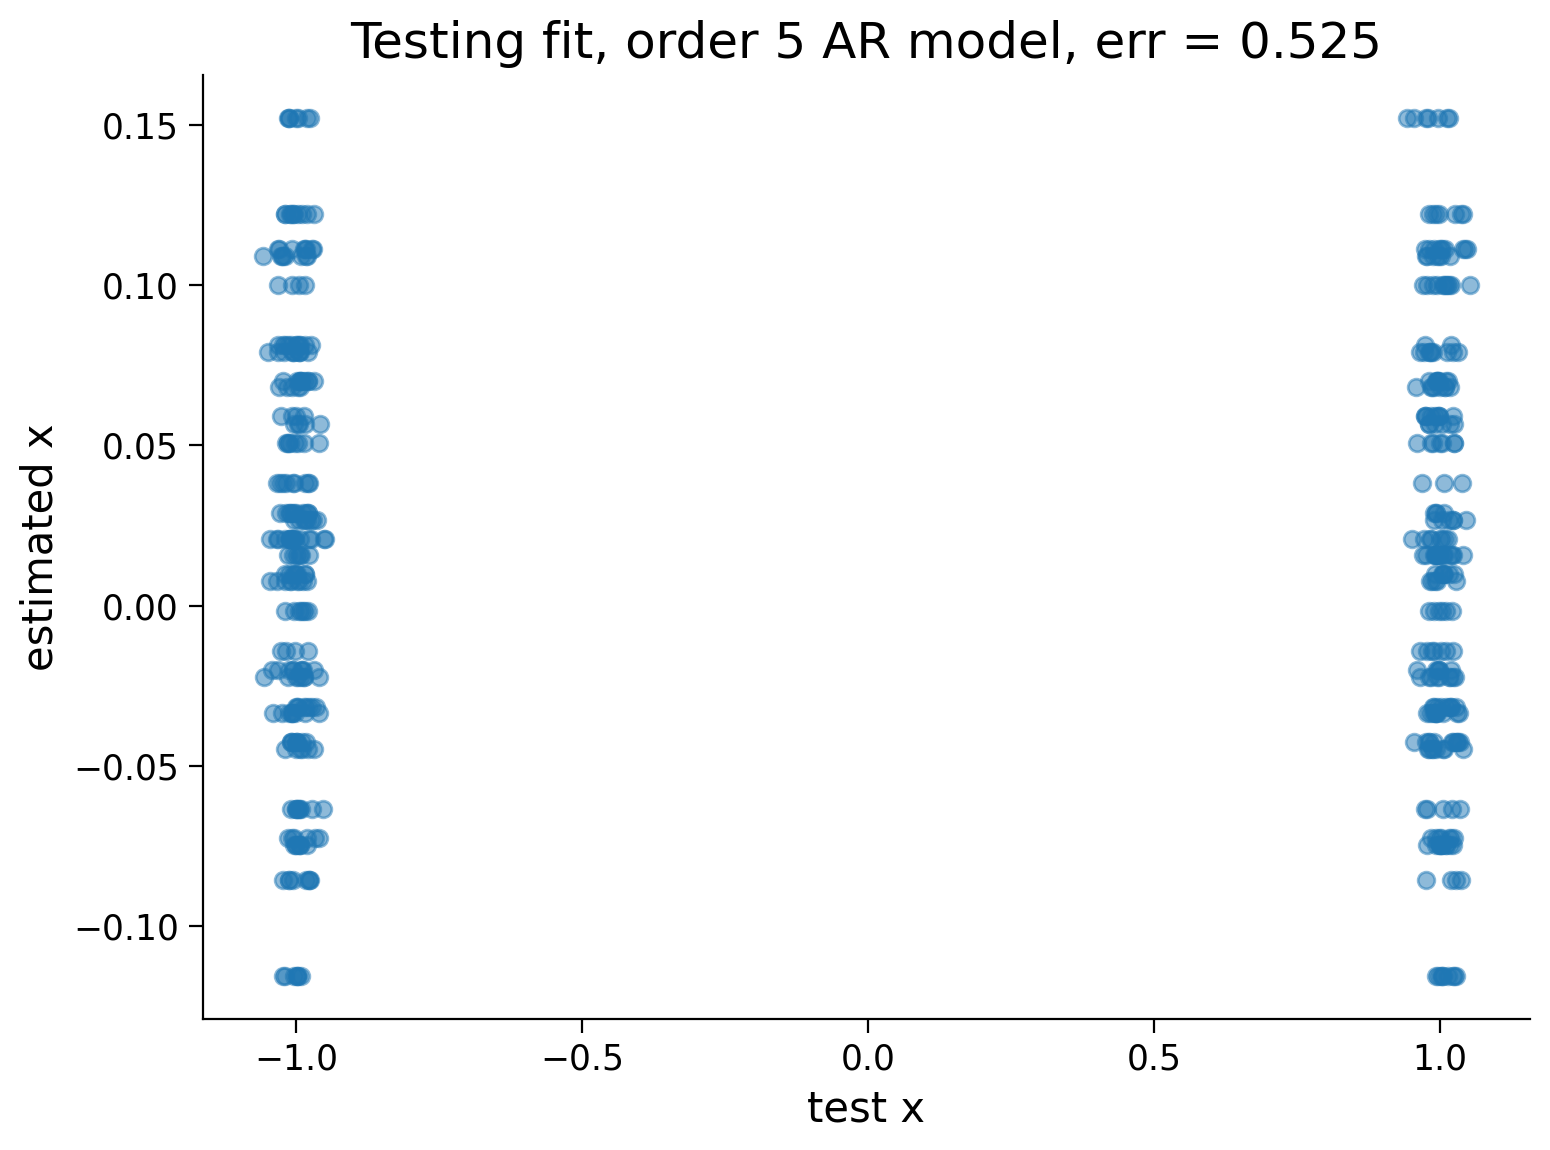

In [20]:
x1_test, x2_test = build_time_delay_matrices(test, r)
plt.figure()
plt.scatter(x2_test+np.random.standard_normal(len(x2_test))*0.02,
            np.dot(x1_test.T, p), alpha=0.5)
mytitle = f'Testing fit, order {r} AR model, err = {error_rate(test, p):.3f}'
plt.title(mytitle)
plt.xlabel('test x')
plt.ylabel('estimated x')
plt.show()

We're getting errors that are around than 0.5, indicating the model is now randomly guessing!

Let's now try **AR models of different orders** systematically, and plot the test error of each.

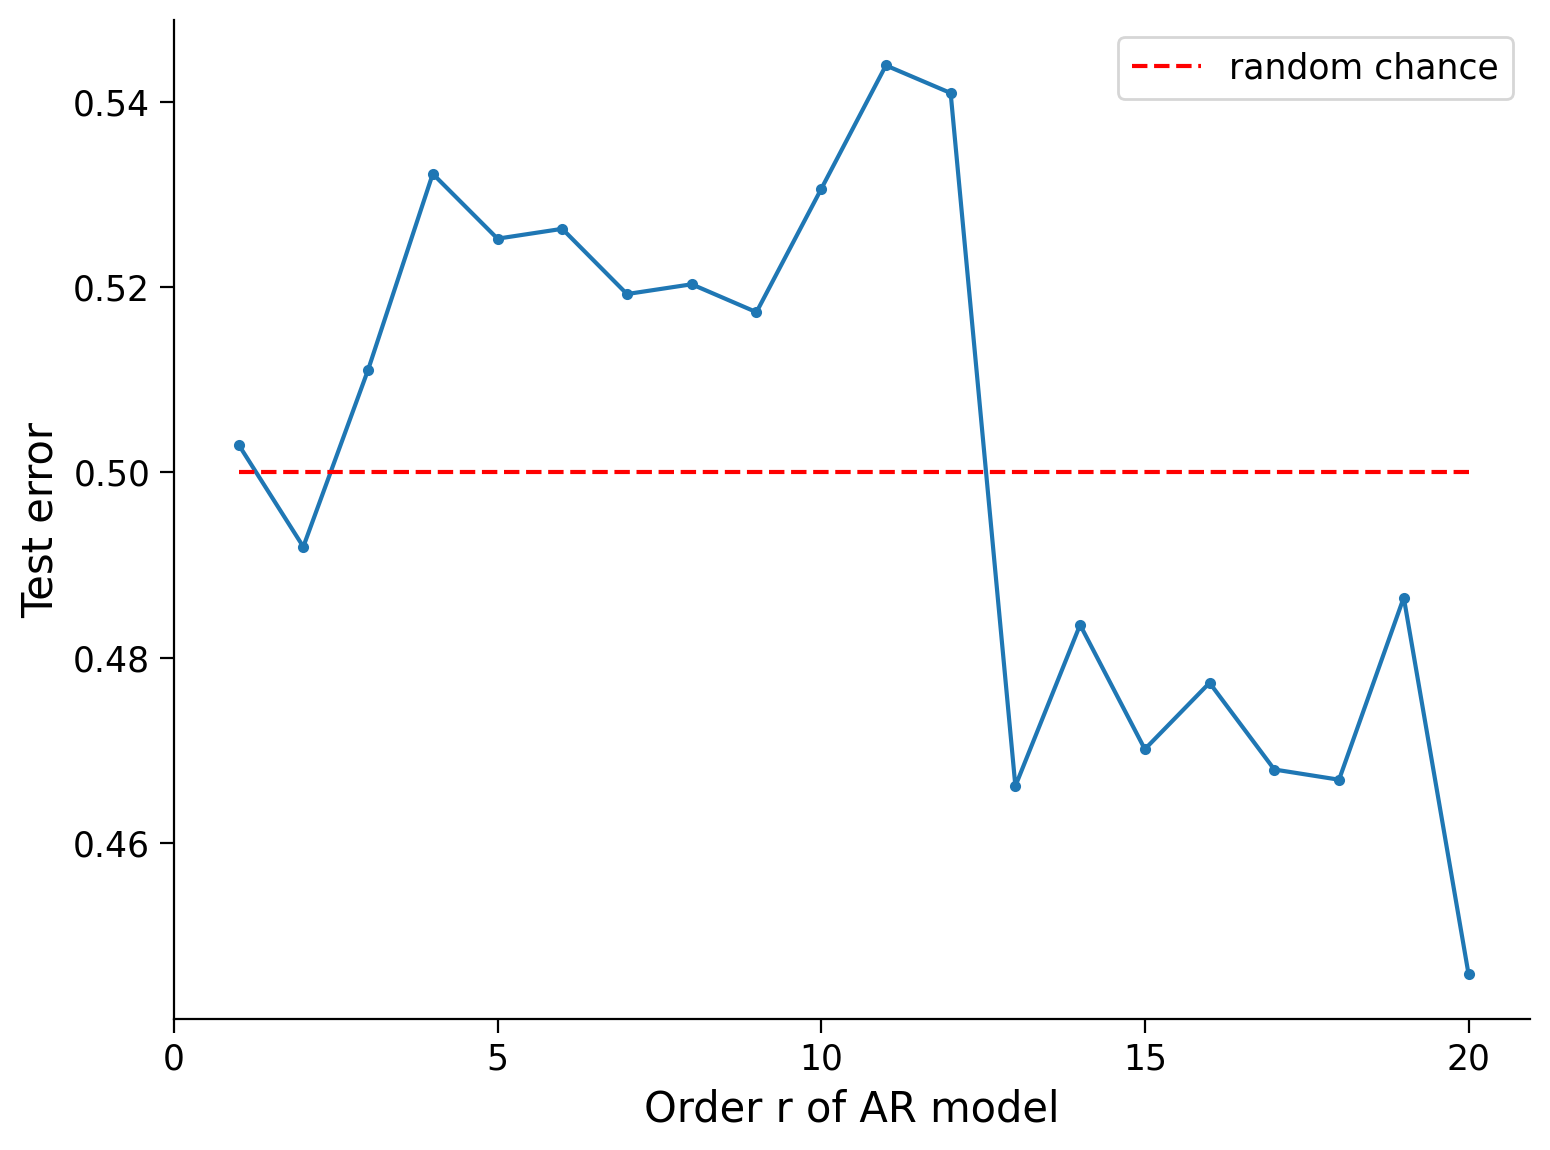

In [21]:
# range of r's to try
r = np.arange(1, 21)
err = np.ones_like(r) * 1.0

for i, rr in enumerate(r):
  # fitting the model on training data
  x1, x2, p = AR_model(x, rr)
  # computing and storing the test error
  test_error = error_rate(test, p)
  err[i] = test_error


plt.figure()
plt.plot(r, err, '.-')
plt.plot([1, r[-1]], [0.5, 0.5], 'r--', label='random chance')
plt.xlabel('Order r of AR model')
plt.ylabel('Test error')
plt.xticks(np.arange(0,25,5))
plt.legend()
plt.show()

The AR model begins slightly errors as $r$ becomes larger. Why is that?

What happens if we increase the $r$ further?

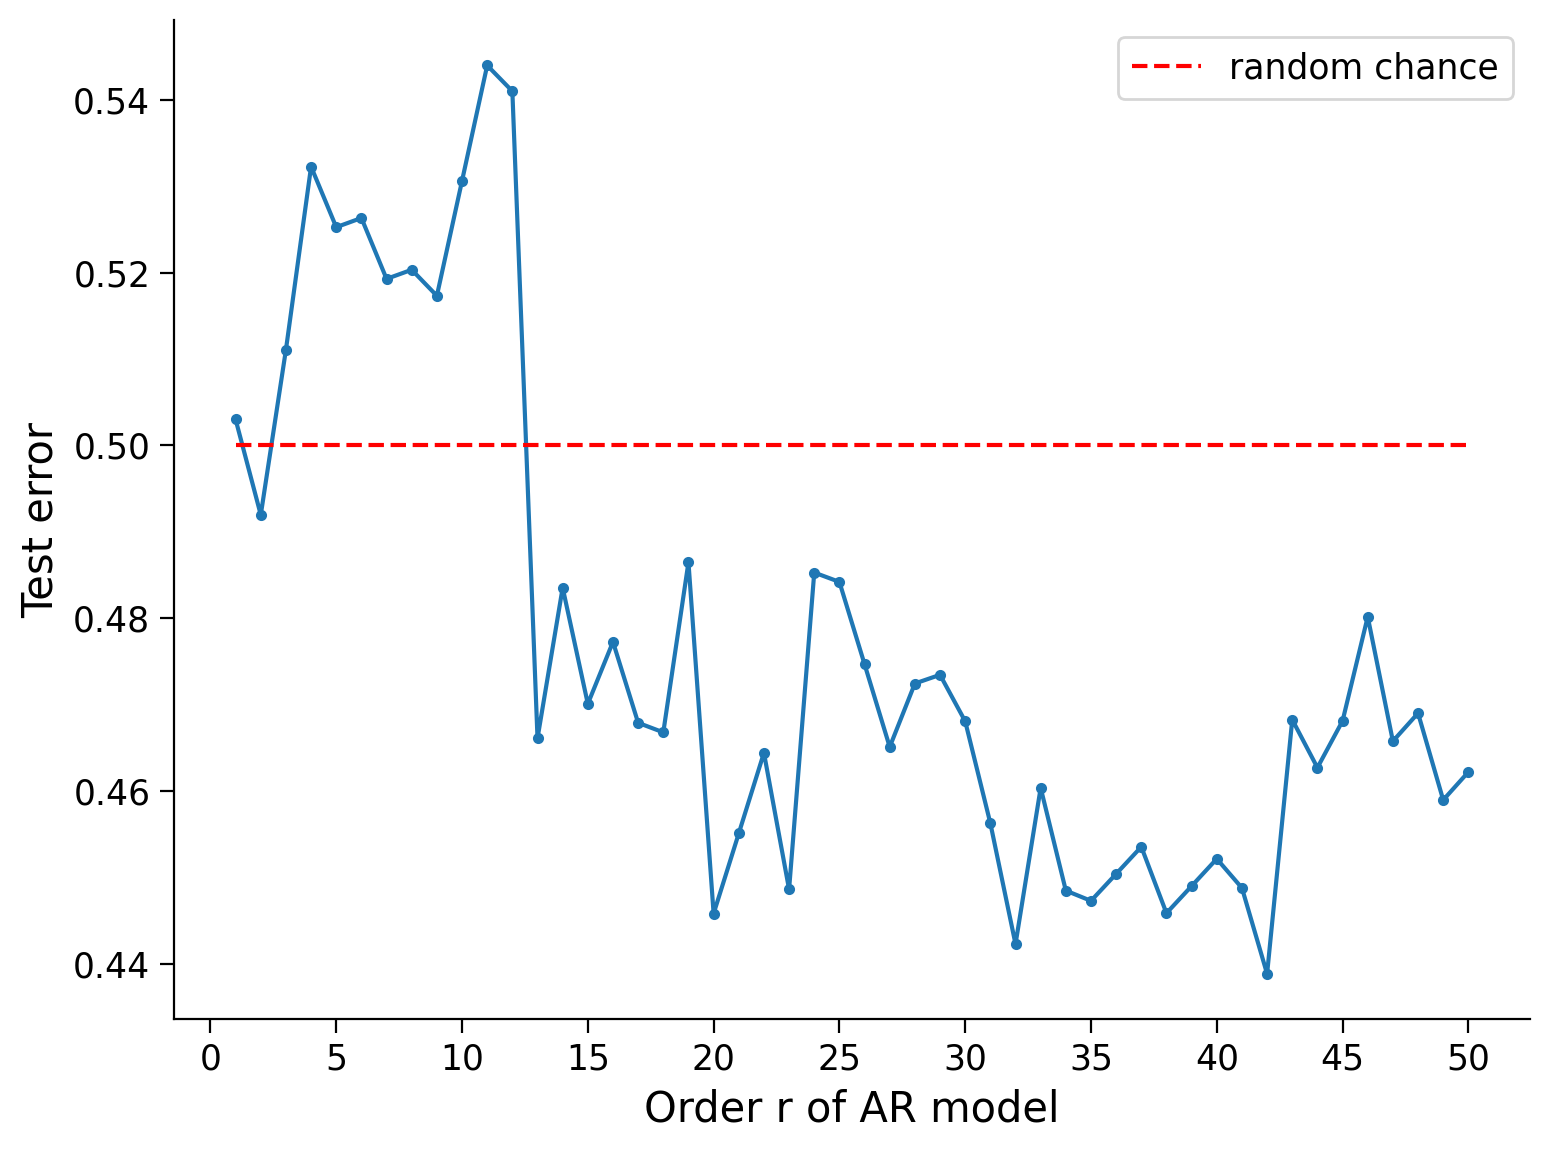

In [39]:
# range of r's to try
r = np.arange(1, 51)
err = np.ones_like(r) * 1.0

for i, rr in enumerate(r):
  # fitting the model on training data
  x1, x2, p = AR_model(x, rr)
  # computing and storing the test error
  test_error = error_rate(test, p)
  err[i] = test_error


plt.figure()
plt.plot(r, err, '.-')
plt.plot([1, r[-1]], [0.5, 0.5], 'r--', label='random chance')
plt.xlabel('Order r of AR model')
plt.ylabel('Test error')
plt.xticks(np.arange(0,55,5))
plt.legend()
plt.show()

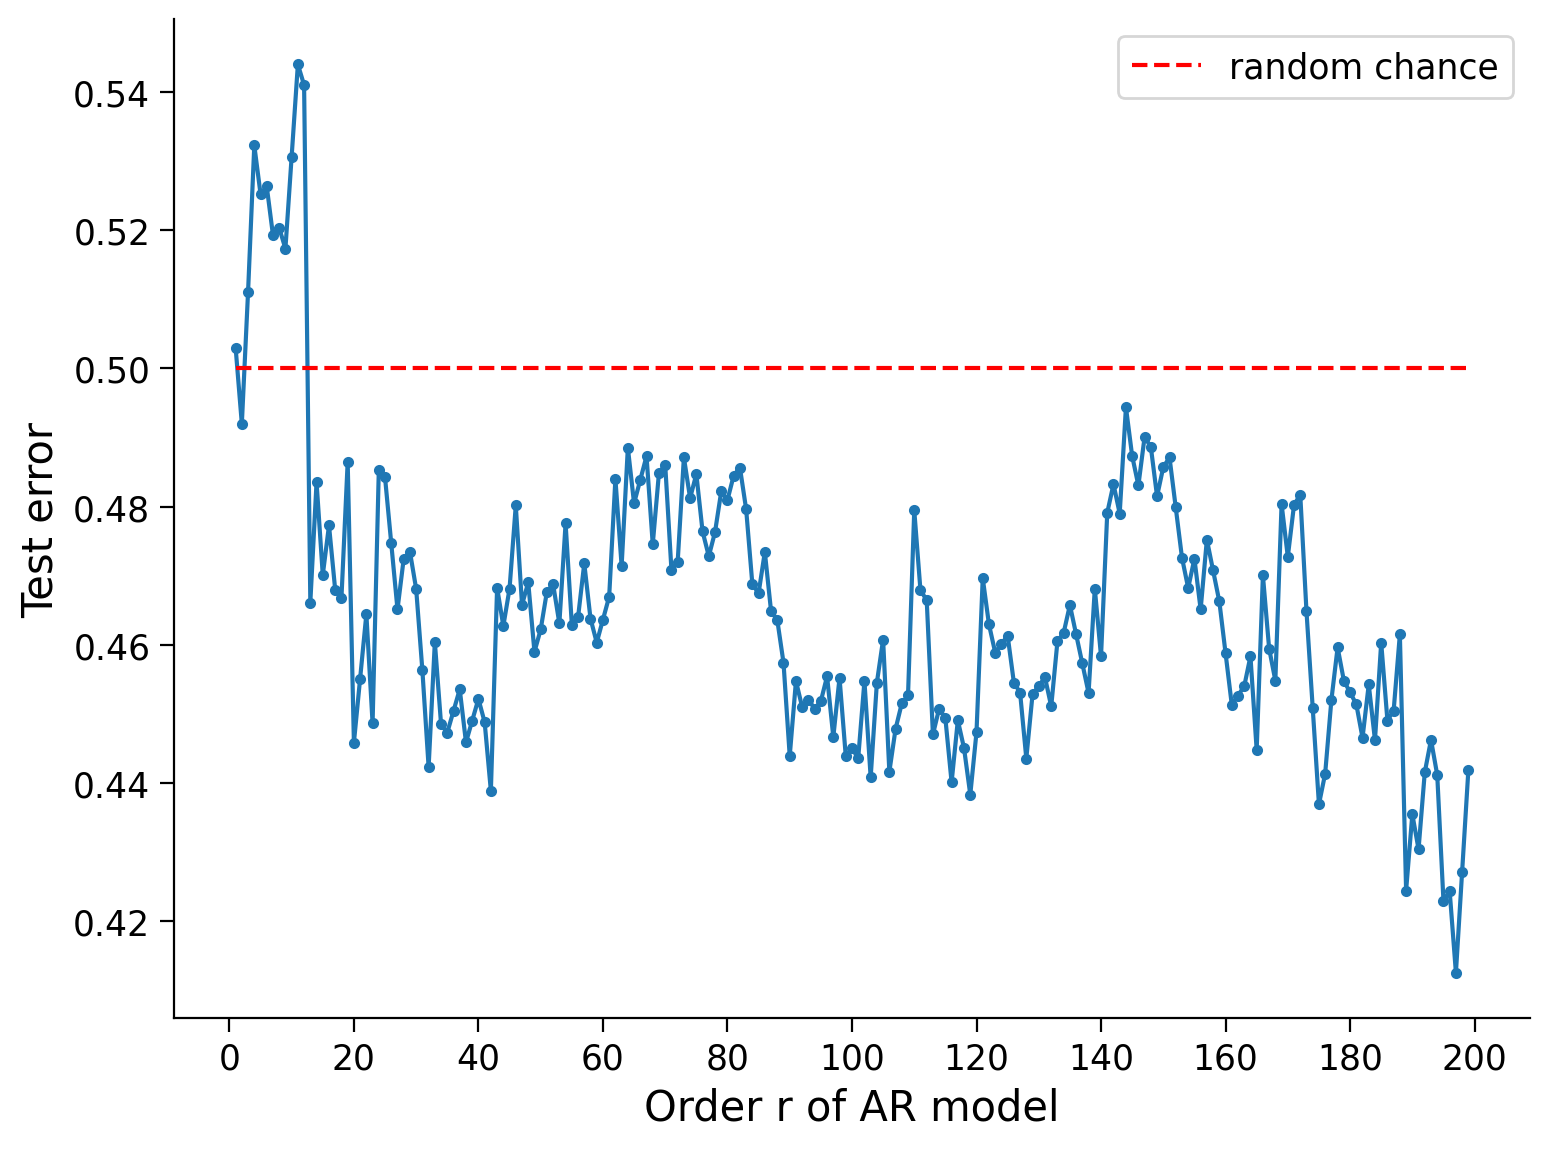

In [37]:
# range of r's to try
r = np.arange(1, 200)
err = np.ones_like(r) * 1.0

for i, rr in enumerate(r):
  # fitting the model on training data
  x1, x2, p = AR_model(x, rr)
  # computing and storing the test error
  test_error = error_rate(test, p)
  err[i] = test_error


plt.figure()
plt.plot(r, err, '.-')
plt.plot([1, r[-1]], [0.5, 0.5], 'r--', label='random chance')
plt.xlabel('Order r of AR model')
plt.ylabel('Test error')
plt.xticks(np.arange(0,205,20))
plt.legend()
plt.show()

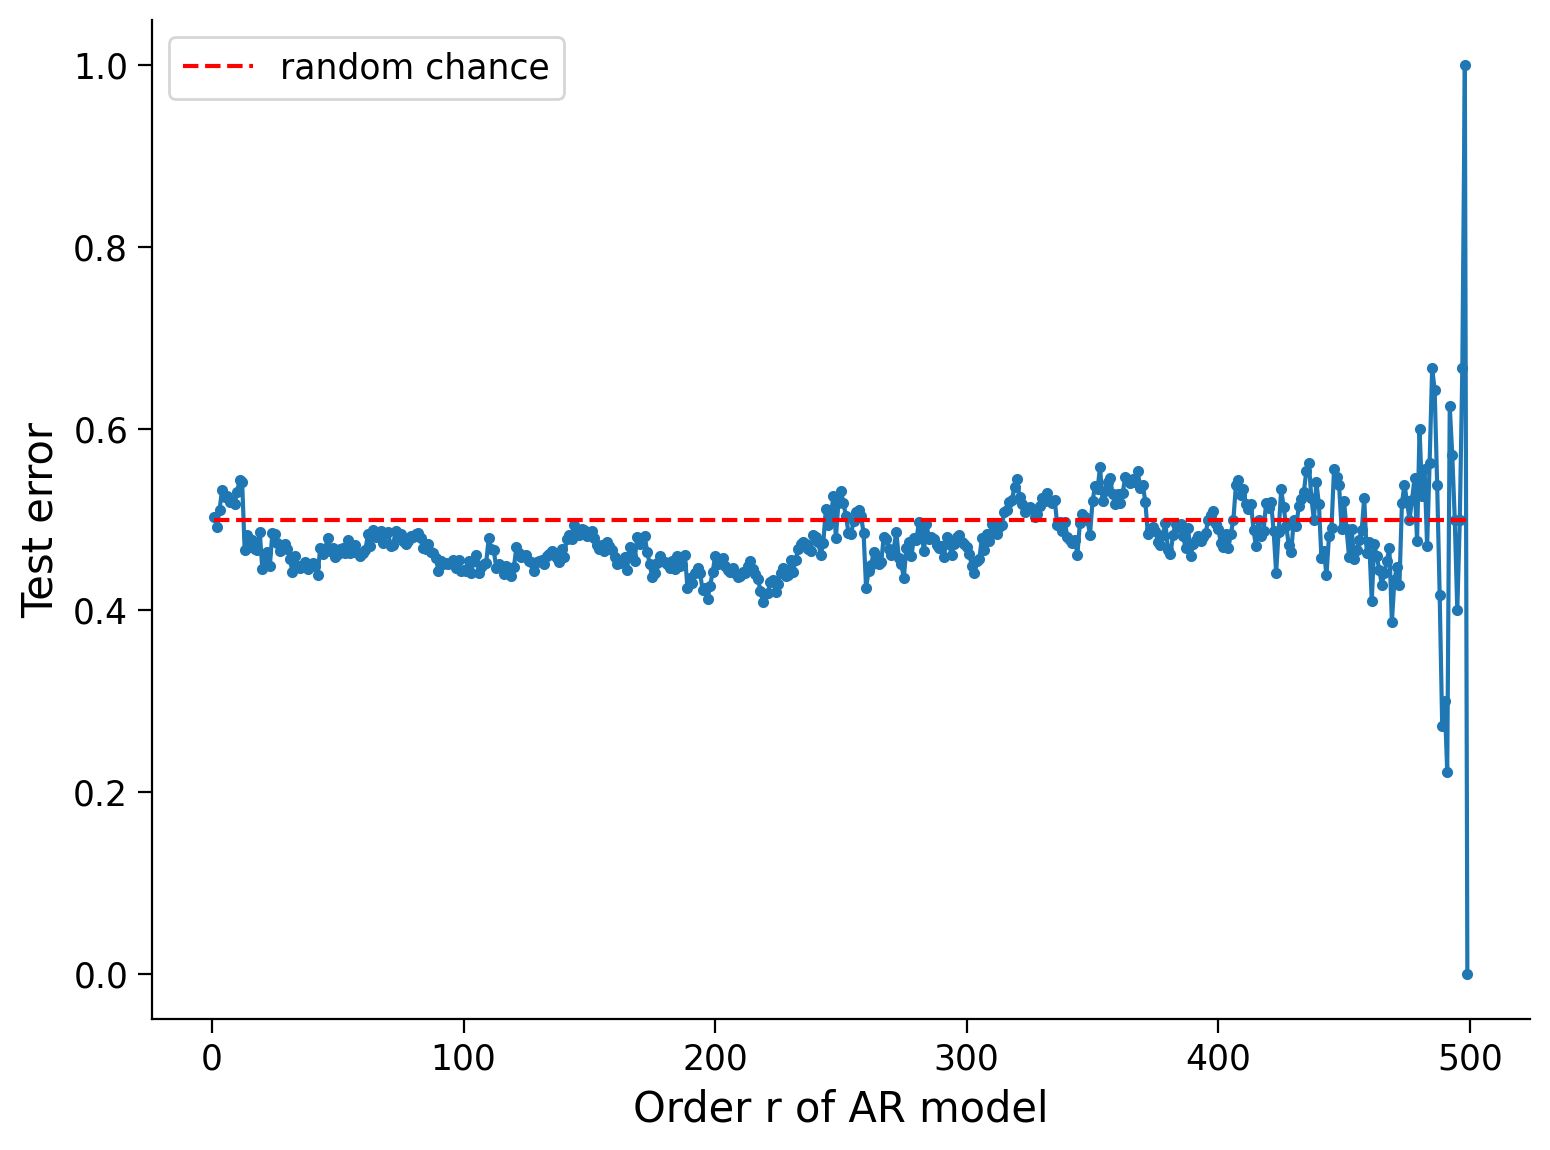

In [40]:
# range of r's to try
r = np.arange(1, 500)
err = np.ones_like(r) * 1.0

for i, rr in enumerate(r):
  # fitting the model on training data
  x1, x2, p = AR_model(x, rr)
  # computing and storing the test error
  test_error = error_rate(test, p)
  err[i] = test_error


plt.figure()
plt.plot(r, err, '.-')
plt.plot([1, r[-1]], [0.5, 0.5], 'r--', label='random chance')
plt.xlabel('Order r of AR model')
plt.ylabel('Test error')
plt.xticks(np.arange(0,505,100))
plt.legend()
plt.show()

Finally, as $r$ increases, approaching the equal number of the machine generated sample size.